# **EasyVisa**

<center><img src="https://tse2.mm.bing.net/th/id/OIP.xDuVe7t90DDqF5nXXwz6FAHaEK?pid=Api&P=0&h=180" width="720"></center>

<center><font size=6>Visa Approval Prediction</font></center>

## **Contents in the notebook**

1. Problem statement and data definition
2. Installing and importing necessary libraries
3. Data ingestion
4. Overview of the data
5. Exploratory Data Analysis (EDA)
6. Data preprocessing
7. Feature engineering
8. Preparing the data for modelling
9. Model building

  a) Modelling with original data

  b) Modelling with undersampled data
  
  c) Modelling with oversampled data using SMOTE
10. Model selection and hypertuning
11. Coclusion and business take aways

### **Problem statement**:

**Context**:

* The U.S. is experiencing high demand for skilled labor, including foreign workers.

* The Office of Foreign Labor Certification (OFLC) handles certification of employer visa applications.

* In 2016, over 775,000 applications were processed for nearly 1.7 million positions.

* The process is growing increasingly tedious and large-scale.

* OFLC partnered with EasyVisa to use machine learning to:

1. Predict visa approval chances

2. Recommend suitable applicant profiles

**Objective**:

Develop a machine learning classification model to predict the approval status of U.S. employer-sponsored visa applications, based on historical data, in order to streamline the visa certification process and recommend suitable applicant profiles.

### **Data description:**

| Feature                 | Description                                                   |
| ----------------------- | ------------------------------------------------------------- |
| `case_id`               | Unique identifier for each visa application                   |
| `continent`             | Continent of the employee’s origin                            |
| `education_of_employee` | Education level of the employee                               |
| `has_job_experience`    | Whether the employee has job experience (`Y`/`N`)             |
| `requires_job_training` | Whether the employee requires job training (`Y`/`N`)          |
| `no_of_employees`       | Number of employees in the employer's company                 |
| `yr_of_estab`           | Year the employer's company was established                   |
| `region_of_employment`  | U.S. region where the job is located                          |
| `prevailing_wage`       | Average wage for the job type in the employment region        |
| `unit_of_wage`          | Unit of wage measurement (Hourly, Weekly, Monthly, Yearly)    |
| `full_time_position`    | Whether the job is full-time (`Y`) or part-time (`N`)         |
| `case_status`           | **Target variable**: whether the visa was certified or denied |


## **Import and install necessary libraries**

In [98]:
# Install XGBoost
!pip install xgboost

#Install catboost
!pip install catboost

# install light gboost
!pip install lightgbm

# install shap
!pip install shap

In [99]:
# For data loading and manipulation
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# To split data
from sklearn.model_selection import train_test_split

# For sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# For model building
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
# Bagging models
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
# Boosting models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# For label encoding
from sklearn.preprocessing import LabelEncoder

# For hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# For model evaluation
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)

# For explainability
import shap

#To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## **Data loading**

In [3]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the dataset
original_data = pd.read_csv('/content/drive/MyDrive/GLAIML/Projects/Module3/EasyVisa.csv')

In [5]:
# Copy the data for transformations and to safeguard the original data
data = original_data.copy()

## **Overview of the data**:

In [6]:
# See how many observations and features are there in the data
data.shape

(25480, 12)

##### **Observation**:
There are 25480 observations and 12 fields (including the target label) in the dataset

In [7]:
# See the first 5 records of the dataset
data.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [8]:
## See the last five rows of the data
data.tail()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601,2008,South,77092.57,Year,Y,Certified
25476,EZYV25477,Asia,High School,Y,N,3274,2006,Northeast,279174.79,Year,Y,Certified
25477,EZYV25478,Asia,Master's,Y,N,1121,1910,South,146298.85,Year,N,Certified
25478,EZYV25479,Asia,Master's,Y,Y,1918,1887,West,86154.77,Year,Y,Certified
25479,EZYV25480,Asia,Bachelor's,Y,N,3195,1960,Midwest,70876.91,Year,Y,Certified


##### **Observation**:
* Each observation contains various features of the employer and the employee profile of the applicant.
* `case_id` represents the unique application for the applicant.

In [9]:
## See the datatypes of the features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


##### **Observations**:
1. All fields are given appropriate datatypes.
2. No observation has a null value for any field.
3. case_status is the label/ predictive variable.

In [10]:
## See the 5 number summary of the numerical columns
data.describe()

,no_of_employees,yr_of_estab,prevailing_wage
count,25480.000000,25480.000000,25480.000000
mean,5667.043210,1979.409929,74455.814592
std,22877.928848,42.366929,52815.942327
min,-26.000000,1800.000000,2.136700
25%,1022.000000,1976.000000,34015.480000
50%,2109.000000,1997.000000,70308.210000
75%,3504.000000,2005.000000,107735.512500
max,602069.000000,2016.000000,319210.270000


##### **Observations**:



**1. `no_of_employees`**

* **Min value is -26**, which is invalid (number of employees cannot be negative) → **Data quality issue**.
* **Mean is 5667**, but **median is 2109** → Data is **right-skewed** due to some very large values (e.g., max is 602,069).
* Large **std (22,877)** confirms high variability in company sizes.
* **Action**: Consider removing negative or extreme outliers, or applying log transformation for modeling.



**2. `yr_of_estab`**

* **Min = 1800**, which seems unusually old for a company.
* **Max = 2016** → Likely the most recent year of data.
* **Mean = 1979**, **median = 1997** → Slight left skew; could reflect mix of old and new companies.
* **Action**: Verify year values like `1800` for accuracy (may be data entry errors). You may also derive company age (e.g., `2016 - yr_of_estab`).



**3. `prevailing_wage`**

* **Min = 2.13**, which is suspiciously low (likely not a valid wage).
* **Max = 319,210**, with **mean = 74,456** and **median = 70,308** → Possibly **right-skewed**.
* **High std (52,816)** indicates wide spread in wages across roles.
* **Action**: Treat very low wages as potential anomalies, consider wage normalization or bucketing for analysis.

**Possible data preprocessing measures for model building**:

* **Handle outliers** using IQR method or domain limits.
* **Impute or remove invalid values** (e.g., negative employees).
* Consider **scaling or transforming** skewed variables for ML models.
* Add derived features if helpful (e.g., company age).


In [11]:
## Checking for the null values if any
data.isnull().sum()

,0
case_id,0
continent,0
education_of_employee,0
has_job_experience,0
requires_job_training,0
no_of_employees,0
yr_of_estab,0
region_of_employment,0
prevailing_wage,0
unit_of_wage,0


##### **Observation**:
There are no null values as found above

In [12]:
## Checking for the duplicate records
data.duplicated().sum()

np.int64(0)

##### **Observations**:
There are no duplicate records

In [13]:
#Finding the counts of unique value in the label
data['case_status'].value_counts()

,count
case_status,
Certified,17018
Denied,8462


##### **Observation**:
There is imbalance in class as nearly 2/3 of cases are certified and only 1/3 of cases are denied Visa.

## **Exploratory Data Analysis** (EDA)

EDA is conducted to understand the distribution, spread, detection of outliers and relation between the variables. It is performed in two parts:
1. univariate analysis : to get to know each single variable using histogram, boxplot and countplot
2. Multivariate analysis : to understand the relationship between other variables and the target using heatmap, scatterplot and stacked bar plot.

### Univariate analysis

#### Numerical fields

In [14]:
def plot_hist_box(data, variable):

  # Create a figure with 1 row and 2 columns (horizontal layout)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

  # Histogram
  sns.histplot(data=data, x=variable, kde=True, ax=ax1, color='#B22222')
  ax1.set_title(f'Histogram of {variable}')
  ax1.set_xlabel(variable)
  ax1.set_ylabel('Frequency')

  # Boxplot
  sns.boxplot(data=data, x=variable, ax=ax2, color='#003366')
  ax2.set_title(f'Boxplot of {variable}')
  ax2.set_xlabel(variable)
  ax2.set_ylabel('Value')

  # Adjust spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()




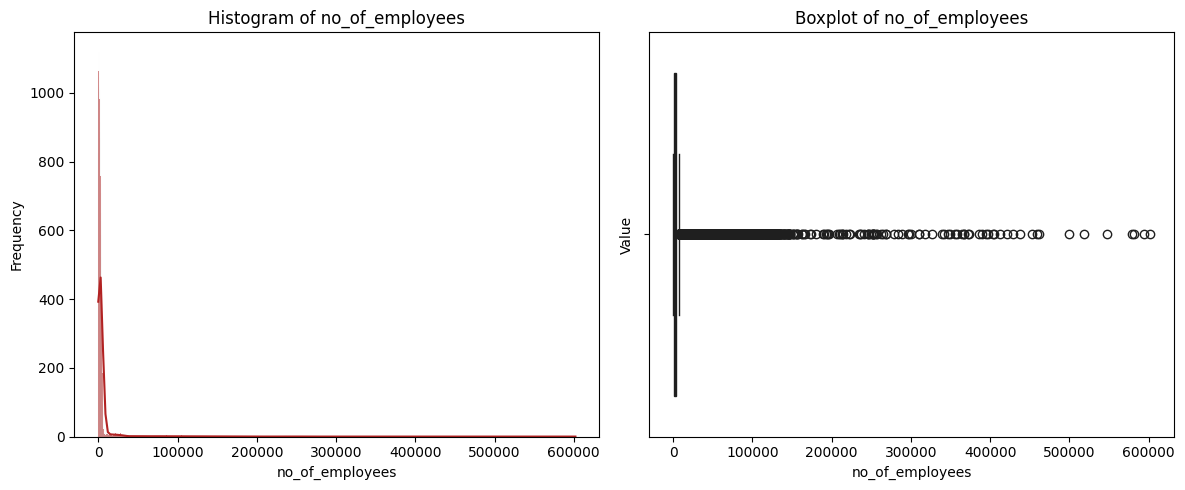

In [15]:
# 1. no_of_employess
plot_hist_box(data, 'no_of_employees')

##### **Observations**:
 **Histogram Observations:**

* The distribution is **heavily right-skewed** (positively skewed).
* A large concentration of values is at the **lower end (near 0–5000)**.
* The frequency quickly drops as the number of employees increases.
* There are very few organizations with extremely high employee counts (>100,000).

**Boxplot Observations:**

* There are a **significant number of outliers** (small circles on the right).
* The **IQR (interquartile range)** is narrow, suggesting most companies fall in a small employee range.
* Some values reach as high as **600,000**, confirming extreme outliers.
* The **median** is positioned toward the lower end of the axis, supporting the histogram's skew.

**Data Quality and Modeling Implications:**

* **Outlier handling** is necessary (e.g., capping, log transformation, or removal).



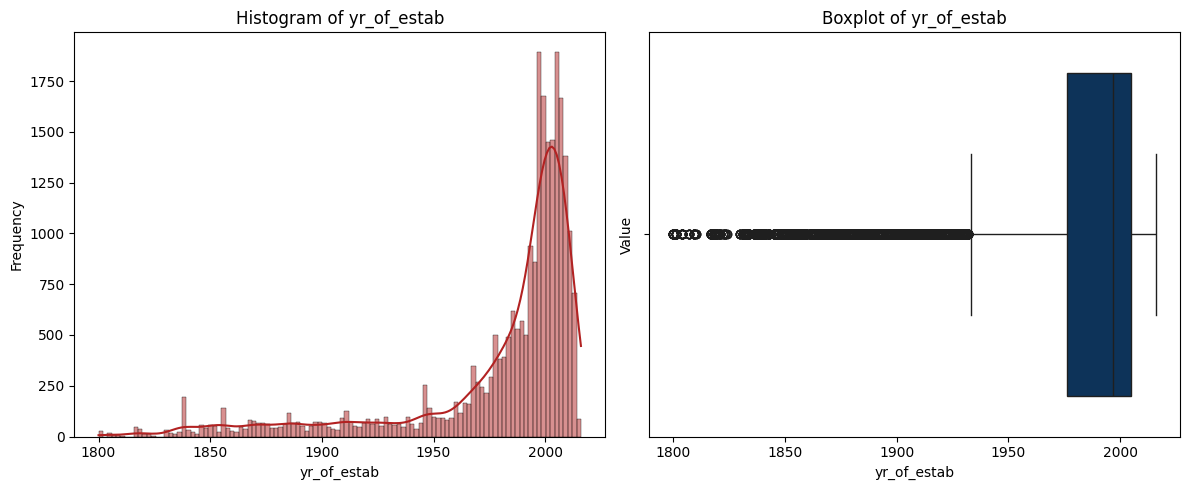

In [16]:
# 2. yr_of_estab
plot_hist_box(data, 'yr_of_estab')

##### **Observations**:
**Histogram Observations**:
1. A sharp rise in company establishments is seen after 1980, peaking around 2000–2010.

2. Very few companies were established before 1900, though some records go as far back as 1800.

3. The distribution is right-skewed, meaning most companies are relatively recent.

**Boxplot Observations**:
1. The majority of values lie in a narrow recent range (post-1980), confirming that most companies are newer.

2. Outliers exist on the left, indicating companies with establishment years well before 1900.

3. The median establishment year is between 1990–2000.

**Data Quality and Modeling Implications**:

* Should consider transforming this feature to "company age":
company_age = current_year - yr_of_estab for more meaningful modeling.


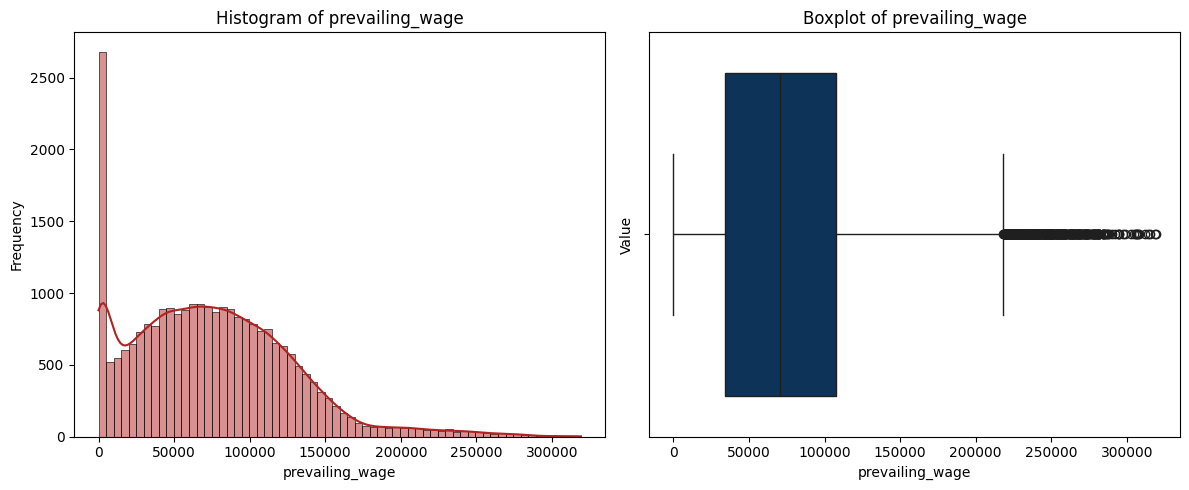

In [17]:
# 3. Prevailing wage
plot_hist_box(data, 'prevailing_wage')

##### **Observations**:

**Histogram Observations:**

* The distribution is **heavily right-skewed**.
* A large number of entries cluster at the **low end**, especially around **0–50,000**.
* A noticeable spike occurs very close to **zero**, which may indicate:

  * **Data entry errors**
  * **Unrealistically low wages**
* The frequency steadily decreases as wage increases, with some values extending beyond **300,000 USD**.

**Boxplot Observations:**

* The **median wage** is somewhere between **70,000–80,000 USD**.
* There are **many outliers** on the higher end, confirming the histogram's long tail.
* The **interquartile range (IQR)** is quite wide, indicating substantial variation in wages.
* Outliers beyond **\~250,000 USD** may need review or treatment depending on modeling needs.

**Data Quality and Modeling Implications:**

* Extremely low wage values (e.g., near 0 or below minimum wage) are **suspicious** — should be either flagged or removed.


#### Categorical fields

In [18]:
# defining the function to create countplot
def plot_count(data, feature):
  fig, ax = plt.subplots(figsize=(12, 5))

  # Define custom palette
  visa_palette = ['#B22222', '#003366', '#D3D3D3', '#DEB887', '#000000']
  # Count unique categories to trim palette
  num_categories = data[feature].nunique()
  adjusted_palette = visa_palette[:num_categories]

  sns.countplot(data=data, x=feature, ax=ax, hue=feature, palette=adjusted_palette, legend=False)
  ax.set_title(f'Frequency of {feature}')
  ax.set_xlabel(feature)
  ax.set_ylabel('Frequency')

  # Adjust spacing between subplots
  plt.tight_layout()

  # Show the plot
  plt.show()

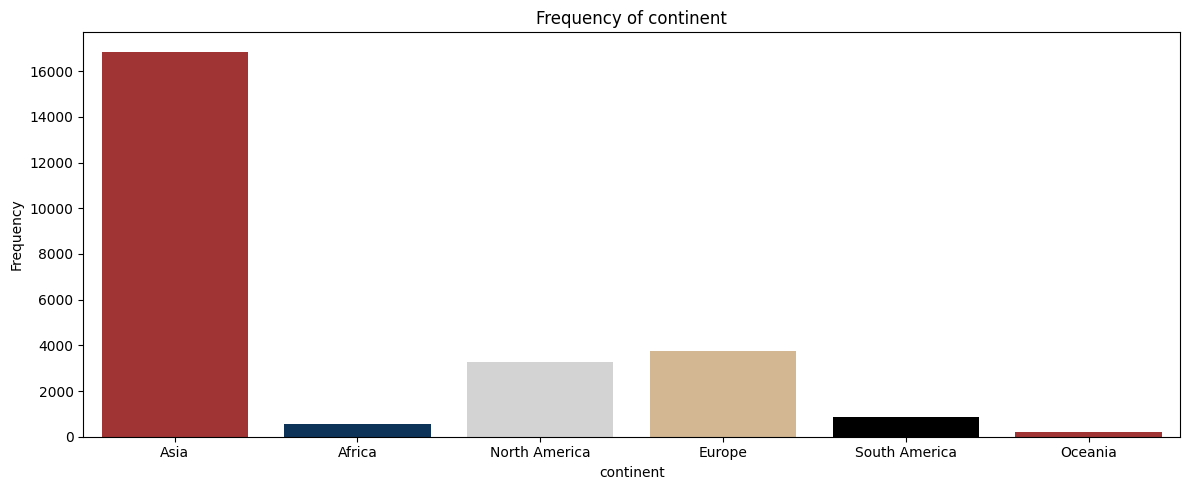

In [19]:
# 1. Continent
plot_count(data, 'continent')

##### **Observations**:
**Asia dominates the dataset**:

* It has the highest number of applicants, significantly more than all other continents combined.

* Suggests a strong visa demand from Asian countries (e.g., India, China, etc.).

* Europe and North America follow:

* Both have moderate representation.

* Likely reflects demand from skilled workers or intra-company transfers.

**Africa, South America, and Oceania have much lower frequencies**:

* Could indicate lower submission volumes or fewer employment-based visa applications from these regions.

* Oceania has the least representation.

**Imbalance in Data**:

* There is a class imbalance in continent distribution, which may affect model performance if continent is used as a feature.

* A model could become biased towards patterns from Asia.

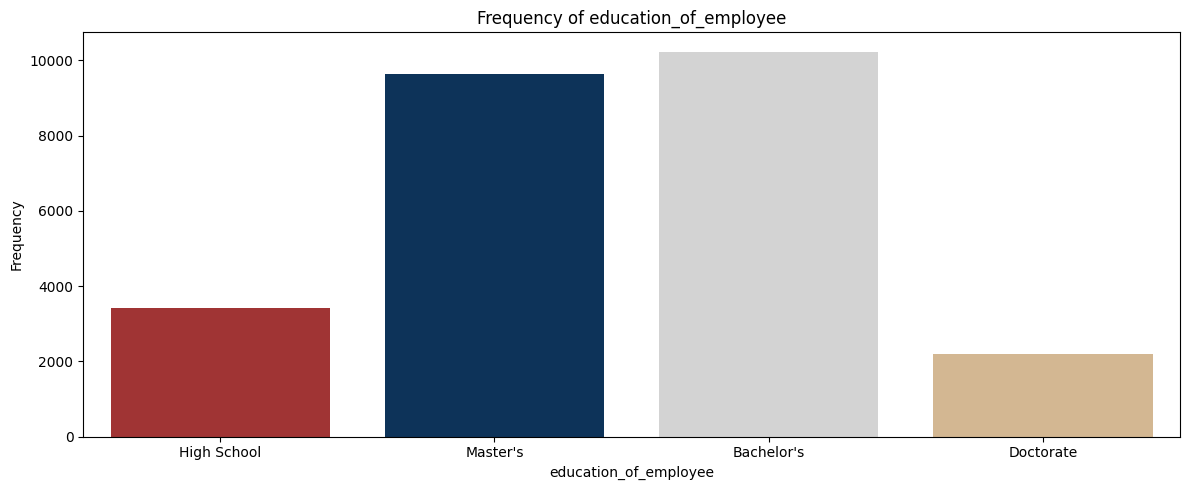

In [20]:
# 2. education_of_employee
plot_count(data, 'education_of_employee')

##### **Observations**:
* Bachelor's degree is the most common education level, with the highest frequency among all categories.

* Master's degree follows closely, indicating a high proportion of employees have postgraduate education.

* High School graduates represent a significantly smaller portion compared to Bachelor's and Master's degree holders.

* Doctorate holders are the least frequent, suggesting that very few employees have pursued education beyond a Master’s degree.

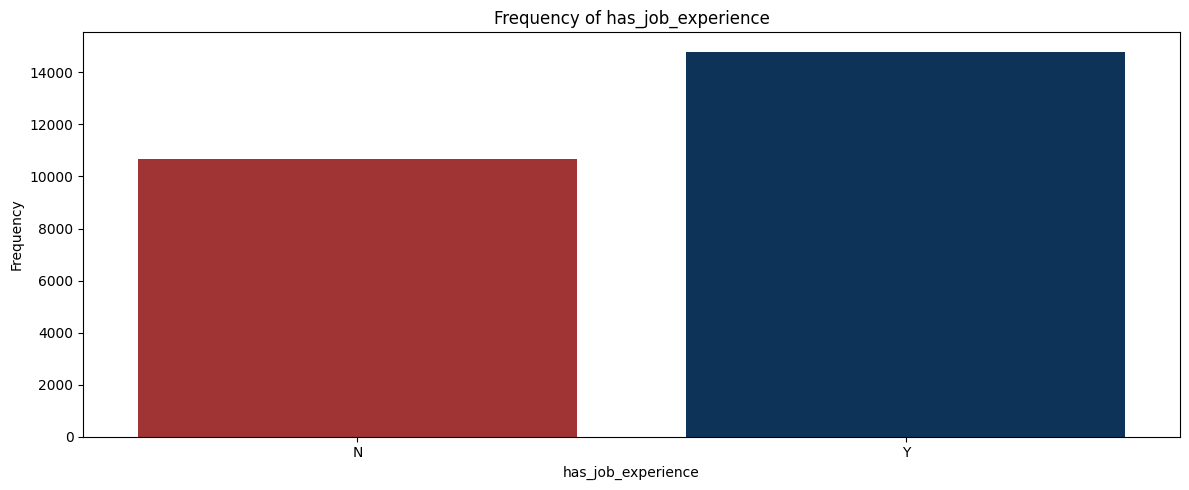

In [21]:
# 3. has_job_experience
plot_count(data, 'has_job_experience')

##### **Observations**:
1. **Majority have prior job experience**

* The count for individuals marked 'Y' (Yes) is higher than those marked 'N' (No).

* This suggests that most individuals in the dataset are not freshers and have relevant past work experience.

2. **Significant portion without experience**

* There is still a substantial number of individuals without job experience, indicating a considerable intake of fresh graduates or entry-level candidates.

3. **Difference is notable but not extreme**

* While experienced individuals are more common, the gap is not extremely wide — suggesting a fair mix of freshers and experienced applicants.

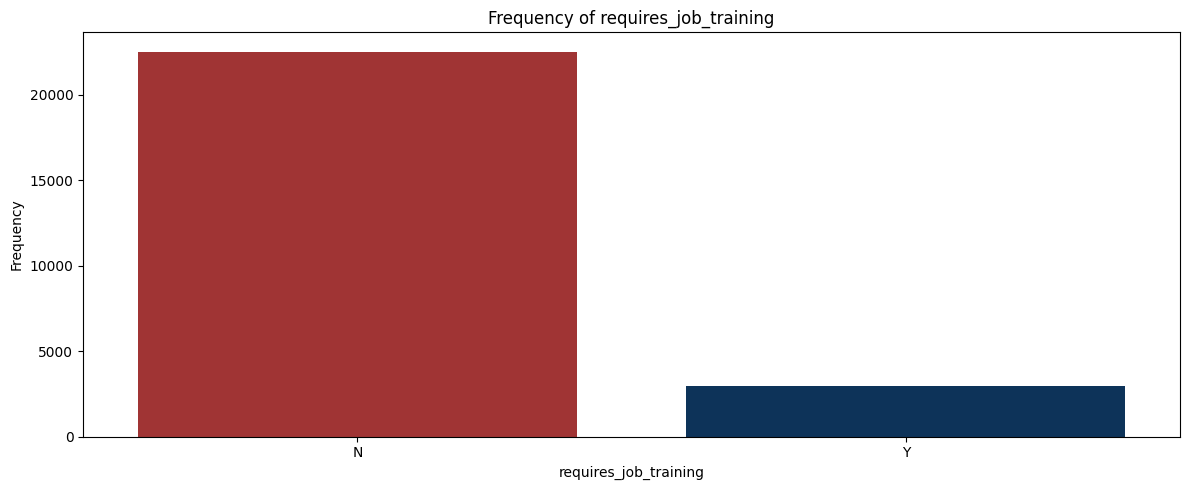

In [22]:
# 4. requires_job_training
plot_count(data, 'requires_job_training')

##### **Observations**:
**Majority do not require job training**

A very high count is associated with 'N' (No), indicating that most individuals are job-ready or already possess the necessary skills.

**Only a small fraction require training**

The count for 'Y' (Yes) is significantly lower, suggesting that very few individuals lack the necessary skills or qualifications and need training.

**Highly imbalanced distribution**

This categorical feature is skewed toward 'N', showing a clear dominance of self-sufficient or skilled candidates in the dataset.

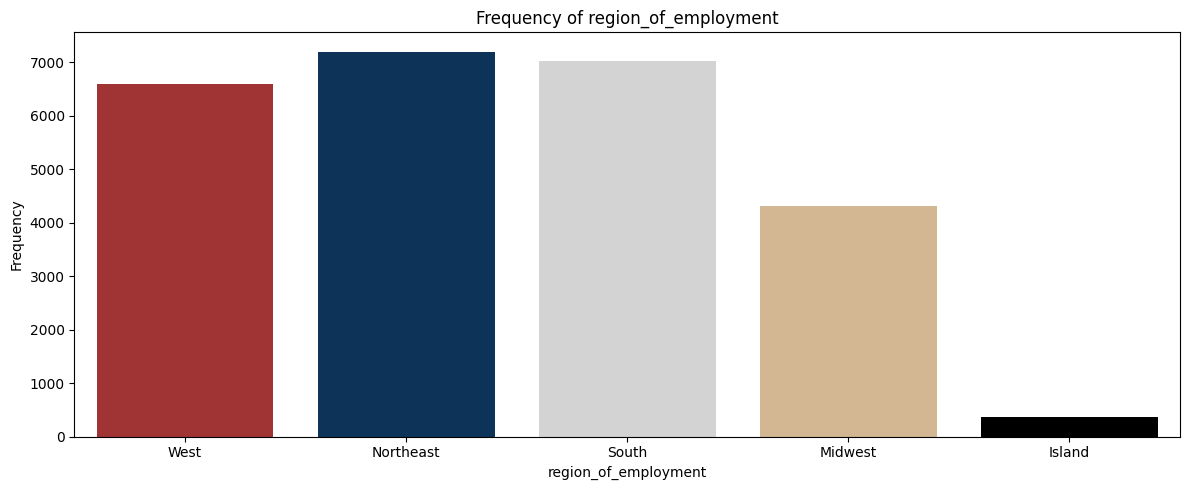

In [23]:
# 5. region_of_employment
plot_count(data, 'region_of_employment')

##### **Observations**:
**Northeast has the highest employment frequency**

It leads slightly above the South and West, indicating it may be a major hub for employment in this dataset.

**South and West regions are also significant**

Both regions show high and comparable frequencies, suggesting they are strong contributors to the workforce as well.

**Midwest has moderate representation**

It ranks lower than the top three, indicating fewer employment opportunities or lower workforce concentration in that region.

**Island region has the lowest frequency by far**

This region is minimally represented, suggesting either geographical limitations, fewer job opportunities, or lower data availability.

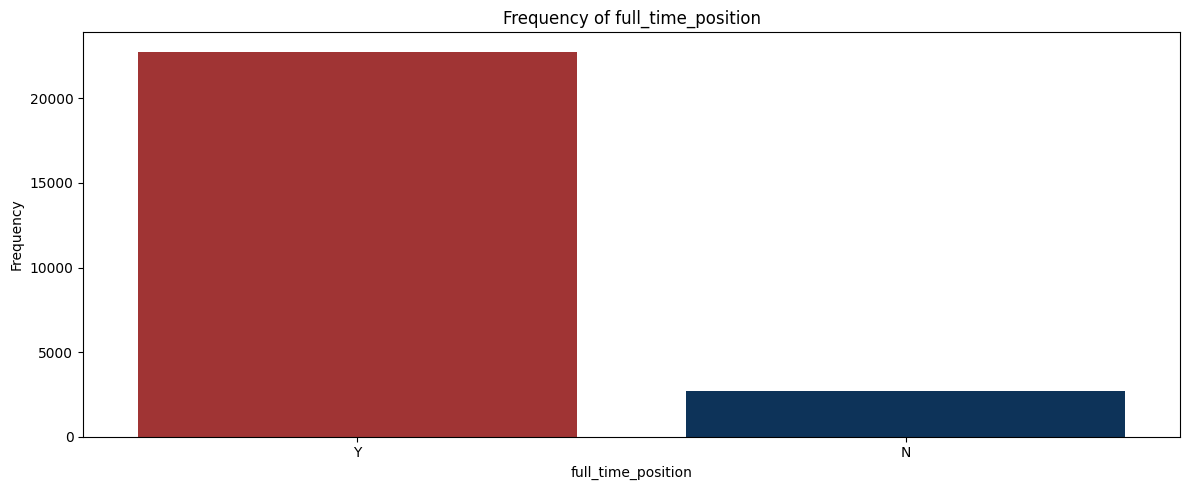

In [24]:
# 6. full_time_position
plot_count(data, 'full_time_position')

##### **Observations**:
**Majority of positions are full-time**

The bar for 'Y' (Yes) is significantly taller than for 'N', indicating that most employees hold full-time positions.

**Relatively few part-time roles**

The 'N' (No) category has a much smaller count, showing that part-time positions are less common in this dataset.

**Skewed distribution toward full-time**

The dataset is heavily imbalanced in favor of full-time employment, suggesting that the organization or domain the data represents is primarily focused on full-time roles.

### Multivariate analysis

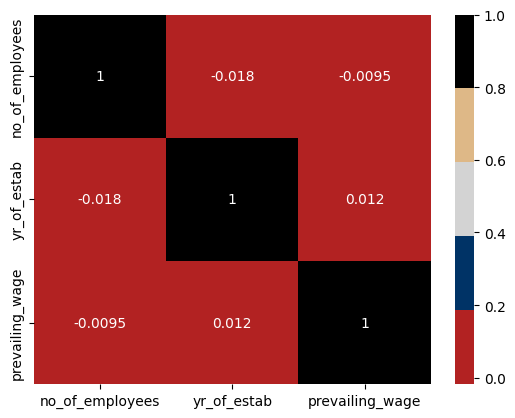

In [25]:
#Plotting heatmap to find correlation between the variables

# Filter numeric columns only
numeric_data = data.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_data.corr()

# Your custom color palette for cmap
visa_palette = ['#B22222', '#003366', '#D3D3D3', '#DEB887', '#000000']

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap=visa_palette)
plt.show()


##### **Observation**:
No strong linear relationships exist among these three variables — all correlation values are close to 0, indicating no significant linear dependency.

Age of establishment (yr_of_estab) has negligible impact on both the number of employees and the prevailing wage.

Wages and employee count also show almost no correlation, suggesting that larger companies don’t necessarily offer higher or lower wages.

These weak correlations imply that other factors may be influencing these variables independently, and they likely do not impact each other directly.

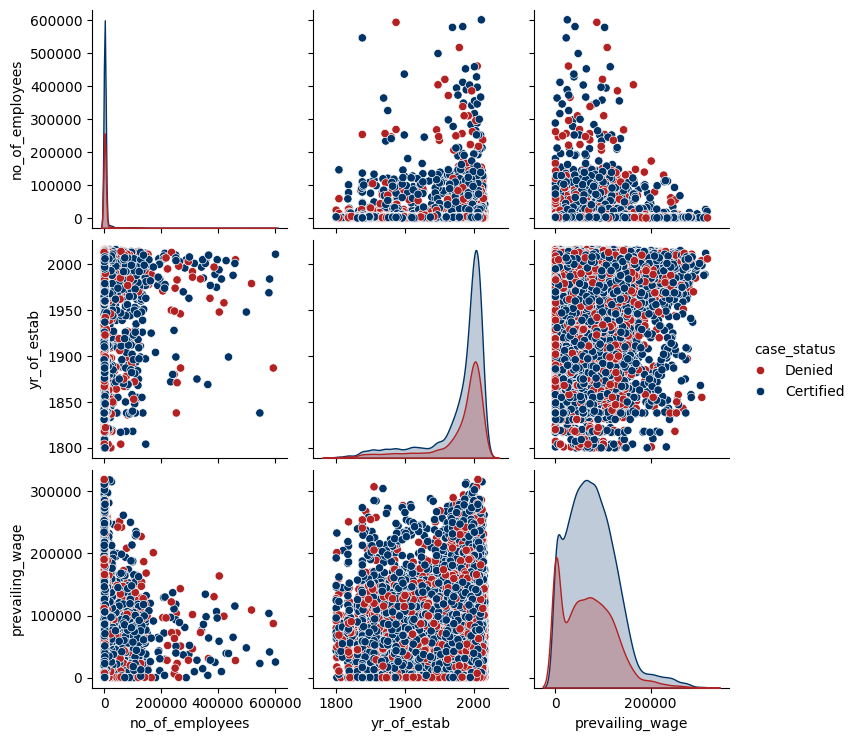

In [26]:
# Plotting the pair plot

#Setting the palette
visa_palette = ['#B22222', '#003366', '#D3D3D3', '#DEB887', '#000000']

#Plot the pairwise scatterplot
sns.pairplot(data, hue='case_status', diag_kind='kde', palette=visa_palette)
plt.show()



##### **Observations**:

**no_of_employees vs yr_of_estab:**

* No visible correlation.

* Companies of all ages have both small and large employee sizes — company age doesn't predict size.

**no_of_employees vs prevailing_wage:**

* Slight inverse trend at the extremes: very high wages tend to occur in smaller companies.

* Still, no clear linear relationship.

**yr_of_estab vs prevailing_wage:**

* Slight positive spread: newer companies may offer slightly higher wages, but the correlation is very weak.

* Some very old companies also offer high wages — overall no consistent trend.

**Interpretation:**
* There are outliers in both wages and employee count, which can skew statistical analysis.

* Most data points are clustered around typical business patterns: modern companies with moderate wages and a reasonable employee count.

* Since the correlation is weak, these variables are likely independent or influenced by other categorical factors (like region, job type, or industry).

In [27]:
def plot_crosstab(data, feature):
    """
    Plots a normalized stacked bar chart (100% stacked) showing case_status distribution
    for a single feature, with percentage labels inside each bar.

    Parameters:
    - data: pandas DataFrame
    - feature: string, name of the categorical column to compare with 'case_status'
    """
    # Create normalized crosstab
    tab = pd.crosstab(data[feature], data['case_status'], normalize='index').sort_values(by='Certified', ascending=False)

    # Plot the stacked bar chart
    ax = tab.plot(kind='bar', stacked=True, figsize=(8, 5), color=['#B22222', '#003366'])

    # Add percentage labels
    for i, col in enumerate(tab.columns):  # for each case_status
        for j, value in enumerate(tab[col]):  # for each category in feature
            if value > 0.02:  # show only if >2%
                y_pos = tab.iloc[j, :i+1].sum() - value / 2  # middle of the bar section
                ax.text(j, y_pos, f'{value*100:.1f}%', ha='center', va='center', fontsize=9, color='white')

    # Aesthetics
    plt.xlabel(feature)
    plt.ylabel('Proportion')
    plt.title(f'Distribution of case_status by {feature}')
    plt.legend(title='case_status', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


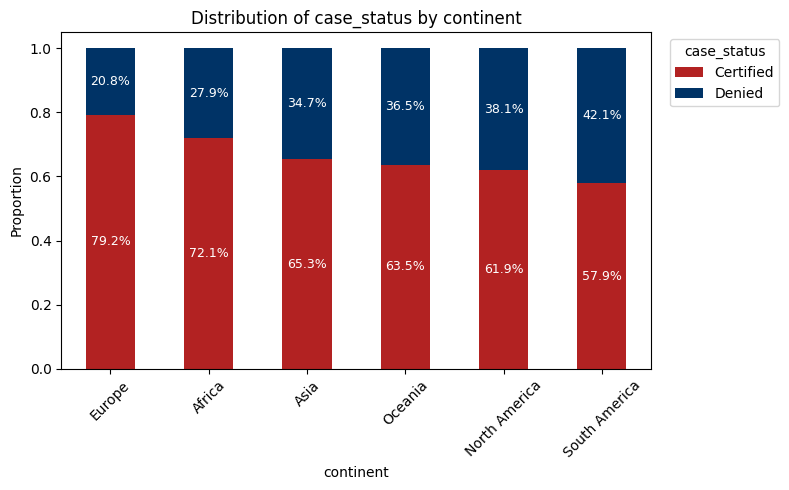

In [28]:
# 1. Continent vs case_status
plot_crosstab(data, 'continent')

##### **Observations**:
Europe has the highest approval rate
**bold text**
The proportion of Certified cases is noticeably higher in Europe compared to other continents, indicating favorable outcomes for applicants from this region.

**Approval rates decline across other continents**

Africa and Asia show moderate certification rates but have visibly higher Denial percentages than Europe.

This might reflect variations in application quality, documentation standards, or regulatory scrutiny.

**South America and North America have relatively higher denial shares**

Particularly South America shows one of the lowest certification ratios, suggesting more rigorous filtering or possibly more incomplete applications.

**Oceania appears neutral or balanced**

The Certified and Denied segments are closer in size compared to Europe or South America, suggesting a more even distribution of outcomes.

**Interpretation**:

The continent of origin seems to be a strong factor associated with case outcomes, possibly due to:

* Country-specific immigration policies or quotas.

* Regional employer reputation or demand-supply alignment.

* Variation in legal/consulting support quality during the application process.

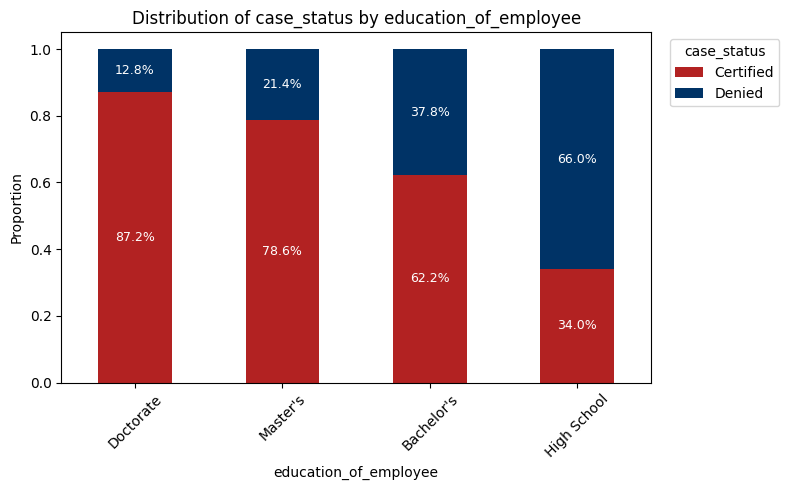

In [29]:
# 2. education of employee
plot_crosstab(data, 'education_of_employee')

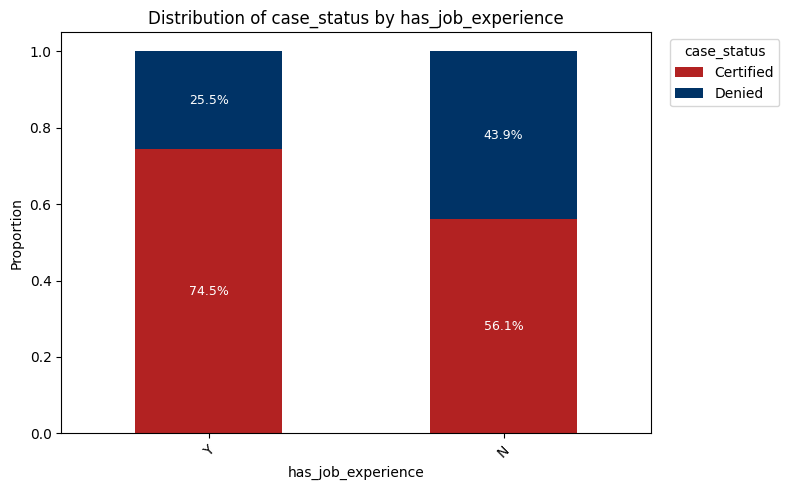

In [30]:
# 3. has job experience
plot_crosstab(data, 'has_job_experience')

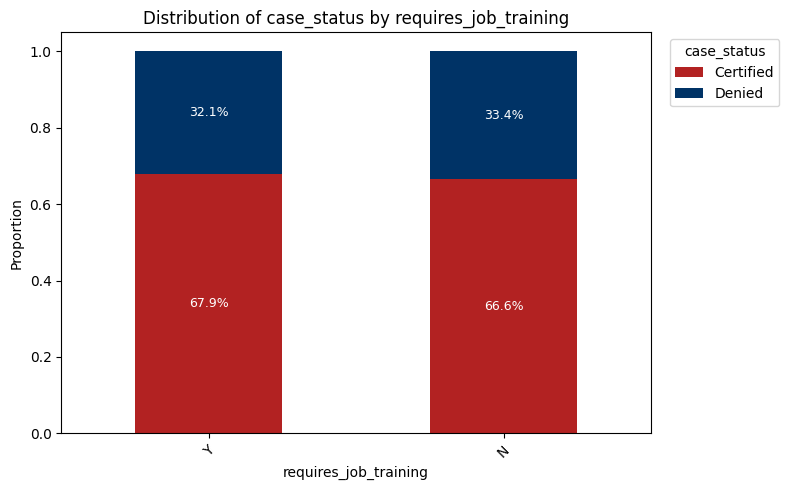

In [31]:
# 4. requires job training
plot_crosstab(data, 'requires_job_training')

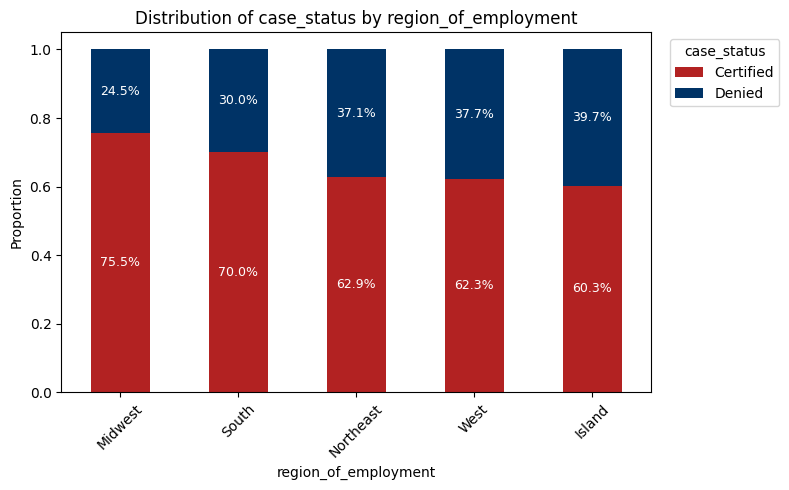

In [32]:
# 5. region_of_employement
plot_crosstab(data, 'region_of_employment')

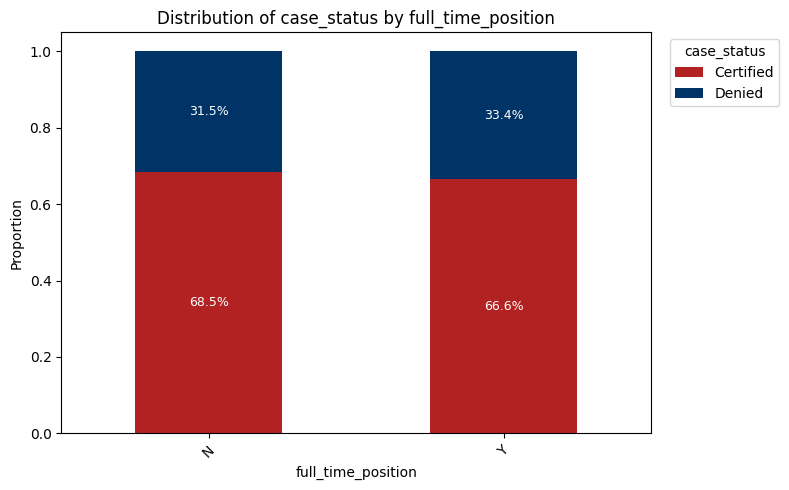

In [33]:
# 6. full_time_position
plot_crosstab(data, 'full_time_position')

## **Data Preprocessing**

1. **Missing value treatment**:
There are no missing values in features, so null value treatment is not required.
2. **Outlier treatment**:

    -> The numerical features are mostly skewed and the values seems possible, so outlier treatment is not required.But the negative values in no_of_employees is a cause of concern and should be capped.

    -> whereas one-hot encoding is required for categorical variables.

3. **Feature engineering**:

    -> The `case_id` which is the unique identifier does not add much value for modelling and can be dropped.

    -> `company_age` could be calculated from `yr_of_estab` (This makes more sense) and the original column could be dropped

    -> Since `prevailing_wage` has different unit, it is good to normalize it and drop the unit_of_wage column

### Outlier treatment


In [34]:
#Capping the `no_of_employees` to minimum
data['no_of_employees'] = data['no_of_employees'].clip(lower=0)

In [35]:
#Cross validating the minimum value in the column
data['no_of_employees'].min()

0

##### **Observation**:
The negative values in the column are clipped.

## **Feature engineering**

In [36]:
# Dropping the case id
data.drop('case_id', axis=1, inplace=True)

In [37]:
#Finding the age of the company from `yr_of_estab`
data['company_age'] = 2025 - data['yr_of_estab']
#Dropping `yr_of_estab`
data.drop('yr_of_estab', axis=1, inplace=True)

In [38]:
data['unit_of_wage'].unique()

array(['Hour', 'Year', 'Week', 'Month'], dtype=object)

In [39]:
# Standardizing `prevailing_wage`
# Standardizing to yearly wage
# 1 year = 52 weeks
# 1 year = 365*24 hours
# 1 year = 12 months
def convert_to_yearly(wage, unit):
  '''
  convert wage to yearly based on the unit
  '''
  if pd.isnull(wage) or pd.isnull(unit):
    return None

  unit = unit.strip().lower()
  if unit == 'year':
    return wage
  elif unit == 'month':
    return wage * 12
  elif unit == 'week':
    return wage * 52
  elif unit == 'hour':
    return wage * 40 * 52 #assuming 40 hour work-week
  else:
    return None

data['prevailing_wage'] = data.apply(lambda row: convert_to_yearly(row['prevailing_wage'], row['unit_of_wage']), axis=1)
data.drop('unit_of_wage', axis=1, inplace=True)

In [40]:
data.describe()

,no_of_employees,prevailing_wage,company_age
count,25480.000000,2.548000e+04,25480.000000
mean,5667.066209,1.973912e+05,45.590071
std,22877.923141,5.785917e+05,42.366929
min,0.000000,1.000000e+02,9.000000
25%,1022.000000,4.710796e+04,20.000000
50%,2109.000000,8.283946e+04,28.000000
75%,3504.000000,1.248250e+05,49.000000
max,602069.000000,1.456915e+07,225.000000


In [41]:
# The max value in the prevailing wage looks like an extreme value which might bias the model, hence capping it
# Calculate the 99% percentile
cap_value = data['prevailing_wage'].quantile(0.99)

# Apply the capping
data['prevailing_wage'] = data['prevailing_wage'].clip(upper = cap_value)

In [42]:
# validating the minimum value in the wage column
data['prevailing_wage'].max()

2036027.1630399968

In [43]:
# Validating the preprocessing changes
data.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,full_time_position,case_status,company_age
0,Asia,High School,N,N,14513,West,1231782.032,Y,Denied,18
1,Asia,Master's,Y,N,2412,Northeast,83425.650,Y,Certified,23
2,Asia,Bachelor's,N,Y,44444,West,122996.860,Y,Denied,17
3,Asia,Bachelor's,N,N,98,West,83434.030,Y,Denied,128
4,Africa,Master's,Y,N,1082,South,149907.390,Y,Certified,20


In [44]:
data.shape

(25480, 10)

##### **Observation**:
After preprocessing and feature engineering:

1. `case_id` the unique identifier is dropped.
2. `no_of_employees` is cleaned of negative values.
3. `company_age` is calculated from `yr_of_estab` and the original column is dropped.
4. `Prevailing_wage` is standardized with units and capped to 99% for the maximum value.
5. The data now contains 25480 ibservations with 11 features and 1 target variable.

## **Preparing data for modelling**

In [45]:
# Splitting features and label
X = data.drop('case_status', axis=1) #Features
y = data['case_status'] #Label

In [46]:
# Creating dummies for categorical variables
X = pd.get_dummies(X, drop_first=True)

# Cast values of the features to float
X = X.astype(float)

In [47]:
X.shape

(25480, 18)

In [48]:
# Creating training and test sets
# Since the label is imbalanced we need to stratify the label
# Since the imbalance is almost 70: 30, propertionate test size benifits990
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# encoding the target labels to train models
y_train_encoded = y_train.map({'Certified': 1, 'Denied': 0})
y_test_encoded = y_test.map({'Certified': 1, 'Denied': 0})

##### **Observation**:
After dummies the number of features is increased to 18 from 10

## **Model building**

**How model can make mistake?**

The model might predict certified Employees as denied (FN), which might cause potential job loss for the employee, a loss of valuable resource and efforts for the employer. Moreover, denying a potential certification wrongly might delay the acquisition of talent needed by businesses, impacting their projects and objectives.

The another case when the model might go wrong is when the application is denied but the model predicted to be certified (FP), in which case there may be overburden for the department to thoroughly evaluate the application and might incur some cost.

**The cost of losing a resource is more than the cost of processing the application. Hence there is a need to minimize the false negatives and add more weight to recall for Certified class. There is a need to boost recall on class 1**



In [49]:
# Function to calculate metrics for the model
# This function is used accross the models
def calculate_metrics(y_true, y_pred):

  # Calculate the scores
  acc = accuracy_score(y_true, y_pred)
  prec = precision_score(y_true, y_pred)
  rec = recall_score(y_true, y_pred, pos_label=1)
  f1 = f1_score(y_true, y_pred, pos_label=1)

  return acc, prec, rec, f1

In [50]:
# Create, train and test different models and calculate their performance
def evaluate_models(X_train, y_train, X_test, y_test, verbose=False):

  #Defining the models
  models = {'DecisionTree': DecisionTreeClassifier(),
            'Bagging':BaggingClassifier(),
            'RandomForest': RandomForestClassifier(),
            'AdaBoost': AdaBoostClassifier(),
            'GradientBoost': GradientBoostingClassifier(),
            'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            'LightGBM': LGBMClassifier(verbose=-1),
            'CatBoost': CatBoostClassifier(verbose=0)}

  #Initializing the performance
  performance = []

  #train each model
  for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]  # probability of class 1

    # Calculating the train and test metrics
    train_acc, train_prec, train_recall, train_f1 = calculate_metrics(y_train, y_train_pred)
    test_acc, test_prec, test_recall, test_f1 = calculate_metrics(y_test, y_test_pred)
    auc_pr = average_precision_score(y_test, y_scores)

    # Preparing the performance df
    performance.append({
        'model': name,
        'train_acc': round(train_acc,4),
        'train_prec': round(train_prec,4),
        'train_recall': round(train_recall,4),
        'train_f1': round(train_f1, 4),
        'test_acc': round(test_acc,4),
        'test_prec': round(test_prec,4),
        'test_recall': round(test_recall,4),
        'test_f1': round(test_f1,4),
        'aur_pr':round(auc_pr, 4)
    })

  #Plot the confusion matrix
  n_models = len(models)
  n_rows = n_models
  n_cols = 2  # Train and Test per row

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))

  if n_models == 1:
      axes = np.array([axes])  # Ensure 2D array if only one model

  # Color maps to make it visually distinct
  color_maps = ['Blues', 'Greens', 'Oranges', 'Purples', 'Reds', 'YlGnBu', 'BuPu', 'cividis', 'cubehelix']

  for i, (name, model) in enumerate(models.items()):
      # Predict train and test
      y_train_pred = model.predict(X_train)
      y_test_pred = model.predict(X_test)

      # Confusion matrices
      cm_train = confusion_matrix(y_train, y_train_pred)
      cm_test = confusion_matrix(y_test, y_test_pred)

      # Row-wise plotting
      cmap = color_maps[i % len(color_maps)]
      sns.heatmap(cm_train, annot=True, fmt='d', cmap=cmap, ax=axes[i, 0])
      axes[i, 0].set_title(f'{name} - Train')
      axes[i, 0].set_xlabel('Predicted')
      axes[i, 0].set_ylabel('Actual')

      sns.heatmap(cm_test, annot=True, fmt='d', cmap=cmap, ax=axes[i, 1])
      axes[i, 1].set_title(f'{name} - Test')
      axes[i, 1].set_xlabel('Predicted')
      axes[i, 1].set_ylabel('Actual')

  plt.tight_layout()
  plt.show()


  return pd.DataFrame(performance).reset_index(drop=True)

### **Models with original data**

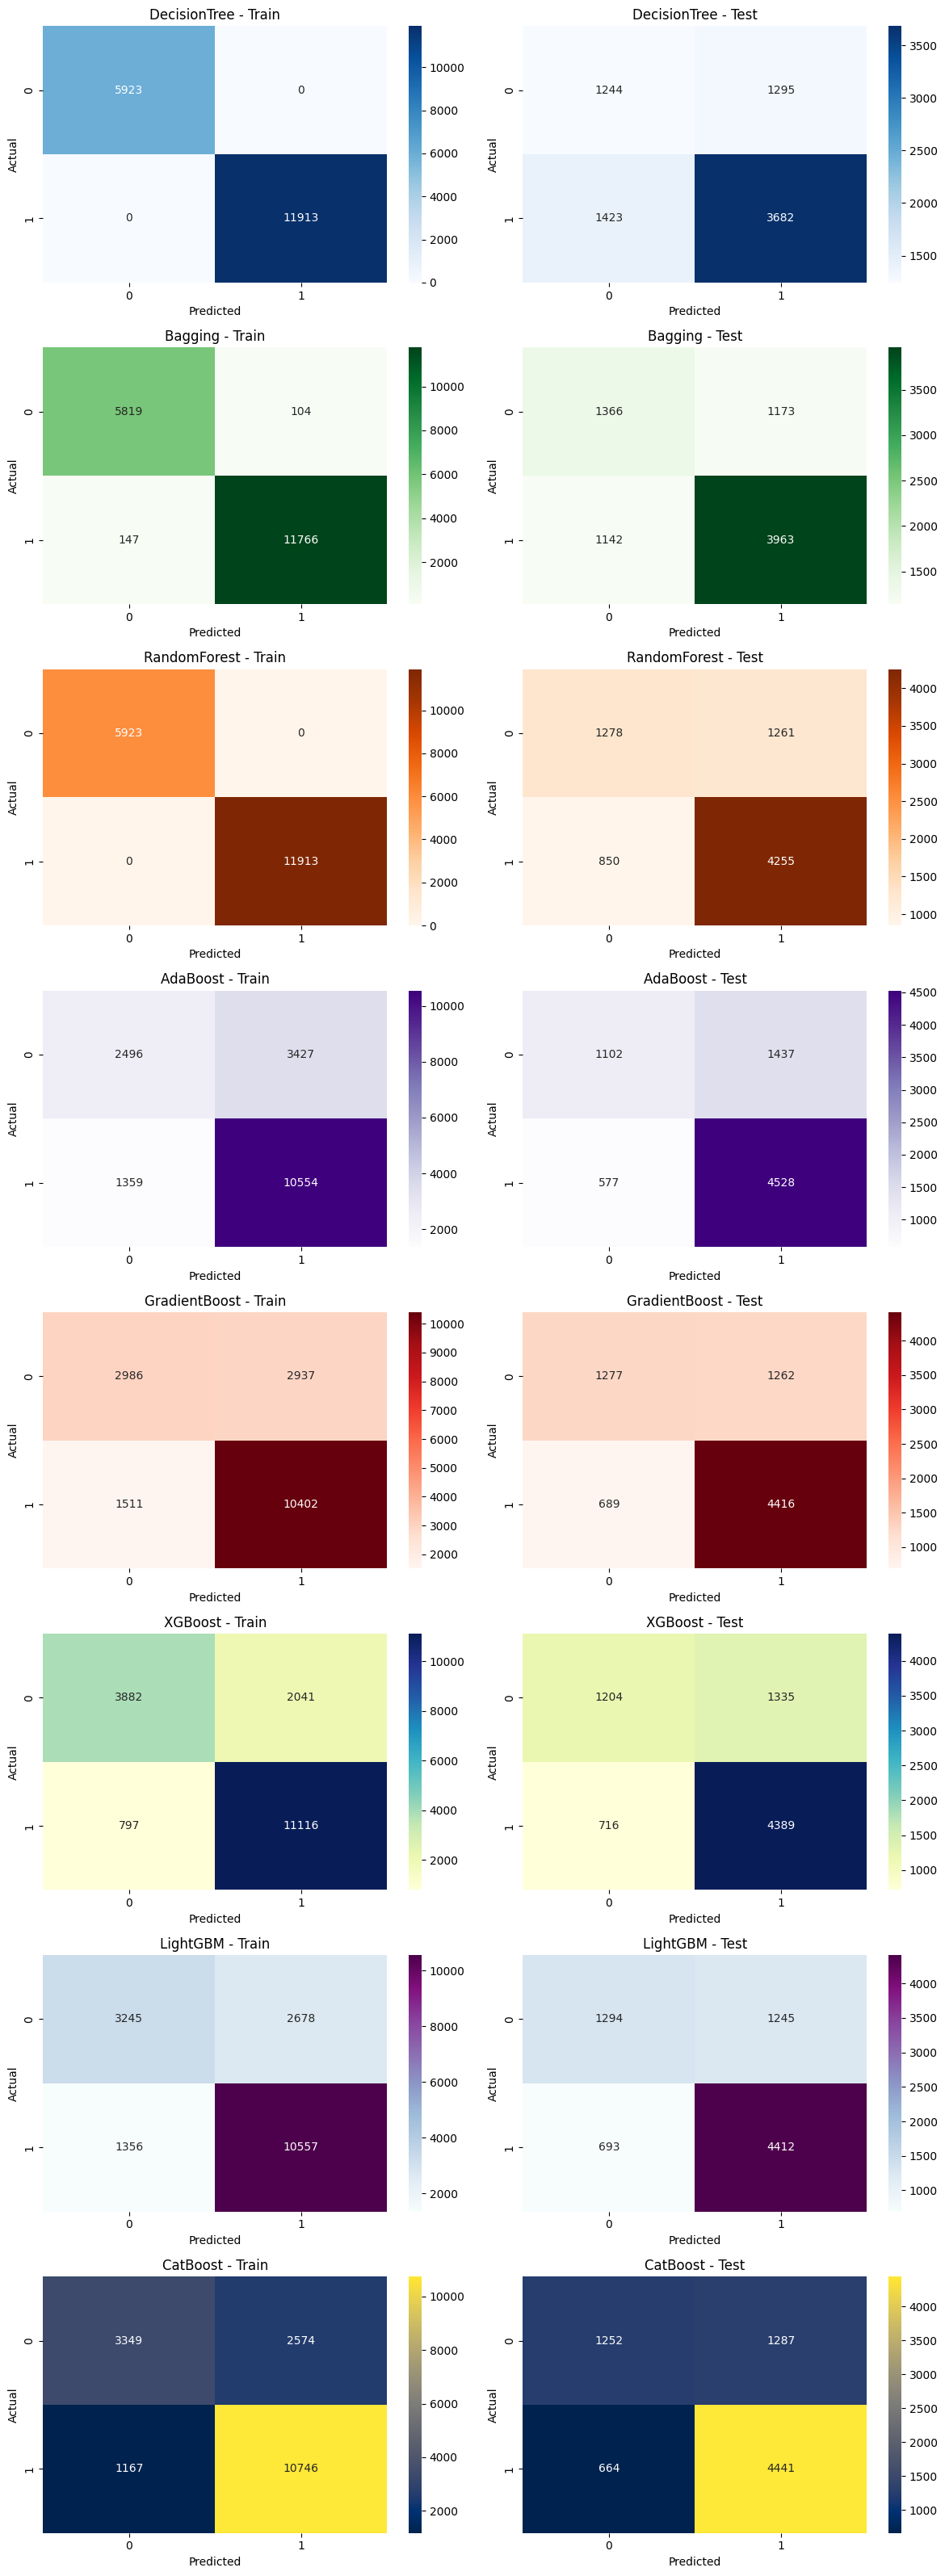

In [51]:
results_df_original = evaluate_models(X_train, y_train_encoded, X_test, y_test_encoded)

In [52]:
results_df_original

,model,train_acc,train_prec,train_recall,train_f1,test_acc,test_prec,test_recall,test_f1,aur_pr
0,DecisionTree,1.0000,1.0000,1.0000,1.0000,0.6444,0.7398,0.7213,0.7304,0.7197
1,Bagging,0.9859,0.9912,0.9877,0.9894,0.6971,0.7716,0.7763,0.7739,0.8216
2,RandomForest,1.0000,1.0000,1.0000,1.0000,0.7238,0.7714,0.8335,0.8012,0.8586
3,AdaBoost,0.7317,0.7549,0.8859,0.8152,0.7365,0.7591,0.8870,0.8181,0.8687
4,GradientBoost,0.7506,0.7798,0.8732,0.8239,0.7448,0.7777,0.8650,0.8191,0.8760
5,XGBoost,0.8409,0.8449,0.9331,0.8868,0.7317,0.7668,0.8597,0.8106,0.8641
6,LightGBM,0.7738,0.7977,0.8862,0.8396,0.7465,0.7799,0.8643,0.8199,0.8806
7,CatBoost,0.7903,0.8068,0.9020,0.8517,0.7448,0.7753,0.8699,0.8199,0.8801


##### **Observations**:
**Problem Context**

*Goal*: Predict if a visa applicant will be certified.

*Risk*: False negatives are costly — wrongly predicting "denied" for someone who actually gets certified.

*Priority*: High recall for the "certified" class (positive class), while keeping F1 and AUC-PR strong.

**Top Observations**
1. *Overfitting in DecisionTree and RandomForest*

	train_acc, train_f1 = 1.0, but low test_acc (0.6436, 0.7233).
	Indicates overfitting, i.e., models memorize training data.
	Not suitable for generalization in real-world deployment.

2. *Boosted Models Outperform Others*

	CatBoost, LightGBM, and GradientBoost have:
	High test_recall (≥ 0.8643)
	High test_f1 (≥ 0.8191)
	High aur_pr (≥ 0.8759)
	These models are better balanced and more robust.
	CatBoost and LightGBM slightly outperform GradientBoost.

3. *Bagging and XGBoost Perform Moderately*

	Bagging: High precision, but lower recall (0.7781) and F1 (0.7749).
	XGBoost: Decent recall (0.8597) but slightly lower AUC-PR (0.8641) than top 3.
	Let's consider them only if CatBoost/LightGBM don't generalize well after tuning.

4. *AdaBoost Shows High Recall but Lower F1*

	Recall = 0.8870 (highest), but F1 = 0.8181.
	Precision is lower (0.7591), meaning more false positives.
	Not ideal for overall balance.

5. *Metric Trade-Offs*

	Precision vs Recall: All models show the typical trade-off — higher recall leads to lower precision.

**For visa approval, favoring recall is safer (accept a few more false positives rather than missing eligible applicants).**

### Suggested models

| Model         | Status           | Reason                                         |
|---------------|------------------|------------------------------------------------|
| CatBoost      | Best choice      | High recall, balanced F1, great AUC-PR         |
| LightGBM      | Best choice      | Close second to CatBoost                       |
| GradientBoost | Very good        | Slightly lower than above two                  |
| XGBoost       | Backup           | Decent but not best in recall                  |
| AdaBoost      | Let's consider them if recall-only needed | High recall, lower F1               |
| Bagging       | Deprioritize     | Lower recall                                   |
| RandomForest  | Overfits         | Perfect train score, poor test                 |
| DecisionTree  | Overfits         | Worst test performance                         |


### **Models with undersampled data**

Undersampling is needed when your dataset is imbalanced, meaning one class (e.g., "Certified") significantly outnumbers the other (e.g., "Denied"). If we train a model directly on imbalanced data, it can learn to always predict the majority class and still get a high accuracy, but poor recall and F1 score for the minority class, which is often the class you're most interested in (e.g., predicting visa denials correctly).

* Problems with imbalanced data:

* The model may ignore the minority class.

* High accuracy but poor performance on important outcomes.

* Misleading evaluation metrics.

But there is risk of losing valuable data

In [53]:
# Creating undersampled data
# Create undersampler
rus = RandomUnderSampler(random_state=42)

# Apply undersampling
X_undersampled, y_undersampled = rus.fit_resample(X, y_train_encoded)

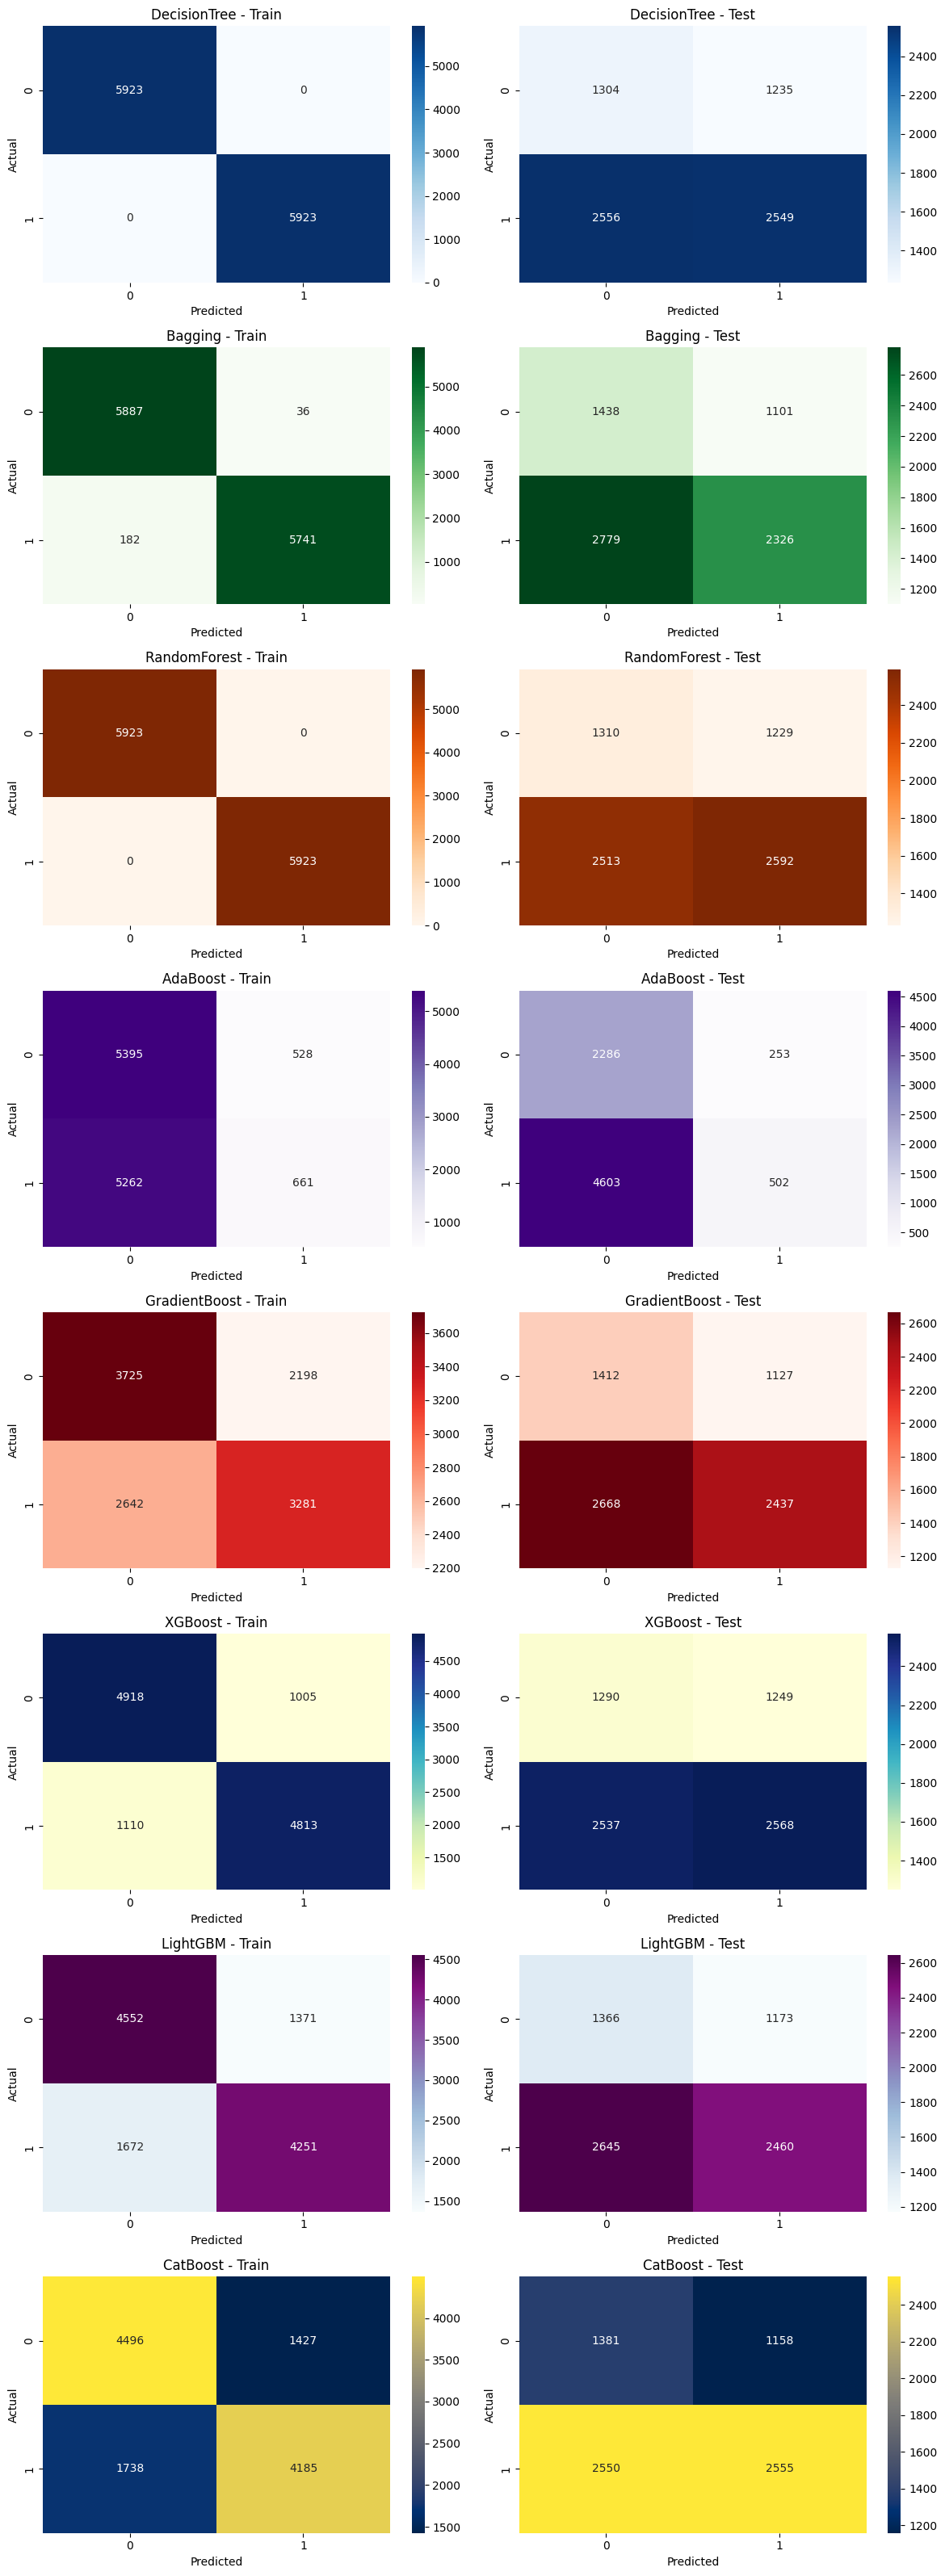

In [54]:
# Creating models with undersampled data
results_df_undersampled = evaluate_models(X_undersampled, y_undersampled, X_test, y_test_encoded)

In [55]:
results_df_undersampled

,model,train_acc,train_prec,train_recall,train_f1,test_acc,test_prec,test_recall,test_f1,aur_pr
0,DecisionTree,1.0000,1.0000,1.0000,1.0000,0.5041,0.6736,0.4993,0.5735,0.6707
1,Bagging,0.9816,0.9938,0.9693,0.9814,0.4924,0.6787,0.4556,0.5452,0.6819
2,RandomForest,1.0000,1.0000,1.0000,1.0000,0.5105,0.6784,0.5077,0.5808,0.6762
3,AdaBoost,0.5112,0.5559,0.1116,0.1859,0.3647,0.6649,0.0983,0.1713,0.6679
4,GradientBoost,0.5914,0.5988,0.5539,0.5755,0.5035,0.6838,0.4774,0.5622,0.6790
5,XGBoost,0.8215,0.8273,0.8126,0.8199,0.5047,0.6728,0.5030,0.5757,0.6671
6,LightGBM,0.7431,0.7561,0.7177,0.7364,0.5005,0.6771,0.4819,0.5631,0.6702
7,CatBoost,0.7328,0.7457,0.7066,0.7256,0.5149,0.6881,0.5005,0.5795,0.6807


##### **Observations**:

**Top Observations**

1. *Severe Overfitting in DecisionTree and RandomForest*

	Both models show perfect training performance (train_acc = 1.0), but poor generalization:

	Test accuracy: ~0.50

	Test recall: ~0.50

	AUC-PR: ~0.67

	Clearly overfit to the training data — not useful in practice.

2. *Boosted Models Are Slightly More Balanced*

	CatBoost and LightGBM show better recall and F1 than others:

	CatBoost: test_recall = 0.5005, test_f1 = 0.5795

	LightGBM: test_recall = 0.4819, test_f1 = 0.5631

	These two are more robust under undersampling — better balance of generalization.

3. *XGBoost Is Moderate*

	Slightly better train/test balance than trees, but:

	test_recall = 0.5005

	test_f1 = 0.5757

	AUC-PR slightly lower than CatBoost/LightGBM

	Acceptable, but not the best under undersampling.

4. *GradientBoost and Bagging Still Underperform*

	GradientBoost:

	Low recall (0.4774) and F1 (0.5622)

	Bagging:

	Lowest F1 of all boosted models (0.5311)

	Both underperform compared to CatBoost/LightGBM.

5. *AdaBoost Fails Completely*

	Very low recall: 0.0983

	F1 score: 0.1713

	Likely underfitting — cannot handle undersampled data well.

	### Suggested models

| Model         | Status           | Reason                                       |
|---------------|------------------|----------------------------------------------|
| CatBoost      | Best choice      | Best F1 and recall under undersampling       |
| LightGBM      | Best choice      | Close second; slightly lower recall          |
| XGBoost       | Very good        | Balanced performance, usable fallback        |
| GradientBoost | Deprioritize     | Lower recall and F1                          |
| Bagging       | Deprioritize     | Poor recall despite high train performance   |
| DecisionTree  | Overfits         | Perfect train, weak test performance         |
| RandomForest  | Overfits         | Same overfitting trend as above              |
| AdaBoost      | Not usable       | Extremely low recall and F1                  |




### **Models with oversampled data**

Building oversampled models in machine learning is a way to handle imbalanced datasets — especially in classification problems where one class is significantly underrepresented (e.g., 90% "No", 10% "Yes"). Without balancing, models tend to bias toward the majority class, leading to poor performance on the minority class. Oversampling should only be done on the training set, not on the full dataset — to avoid data leakage.

In [56]:
# Resampling the train set with random over sampling
os = SMOTE(random_state=42)
X_oversampled, y_oversampled = os.fit_resample(X_train, y_train_encoded)

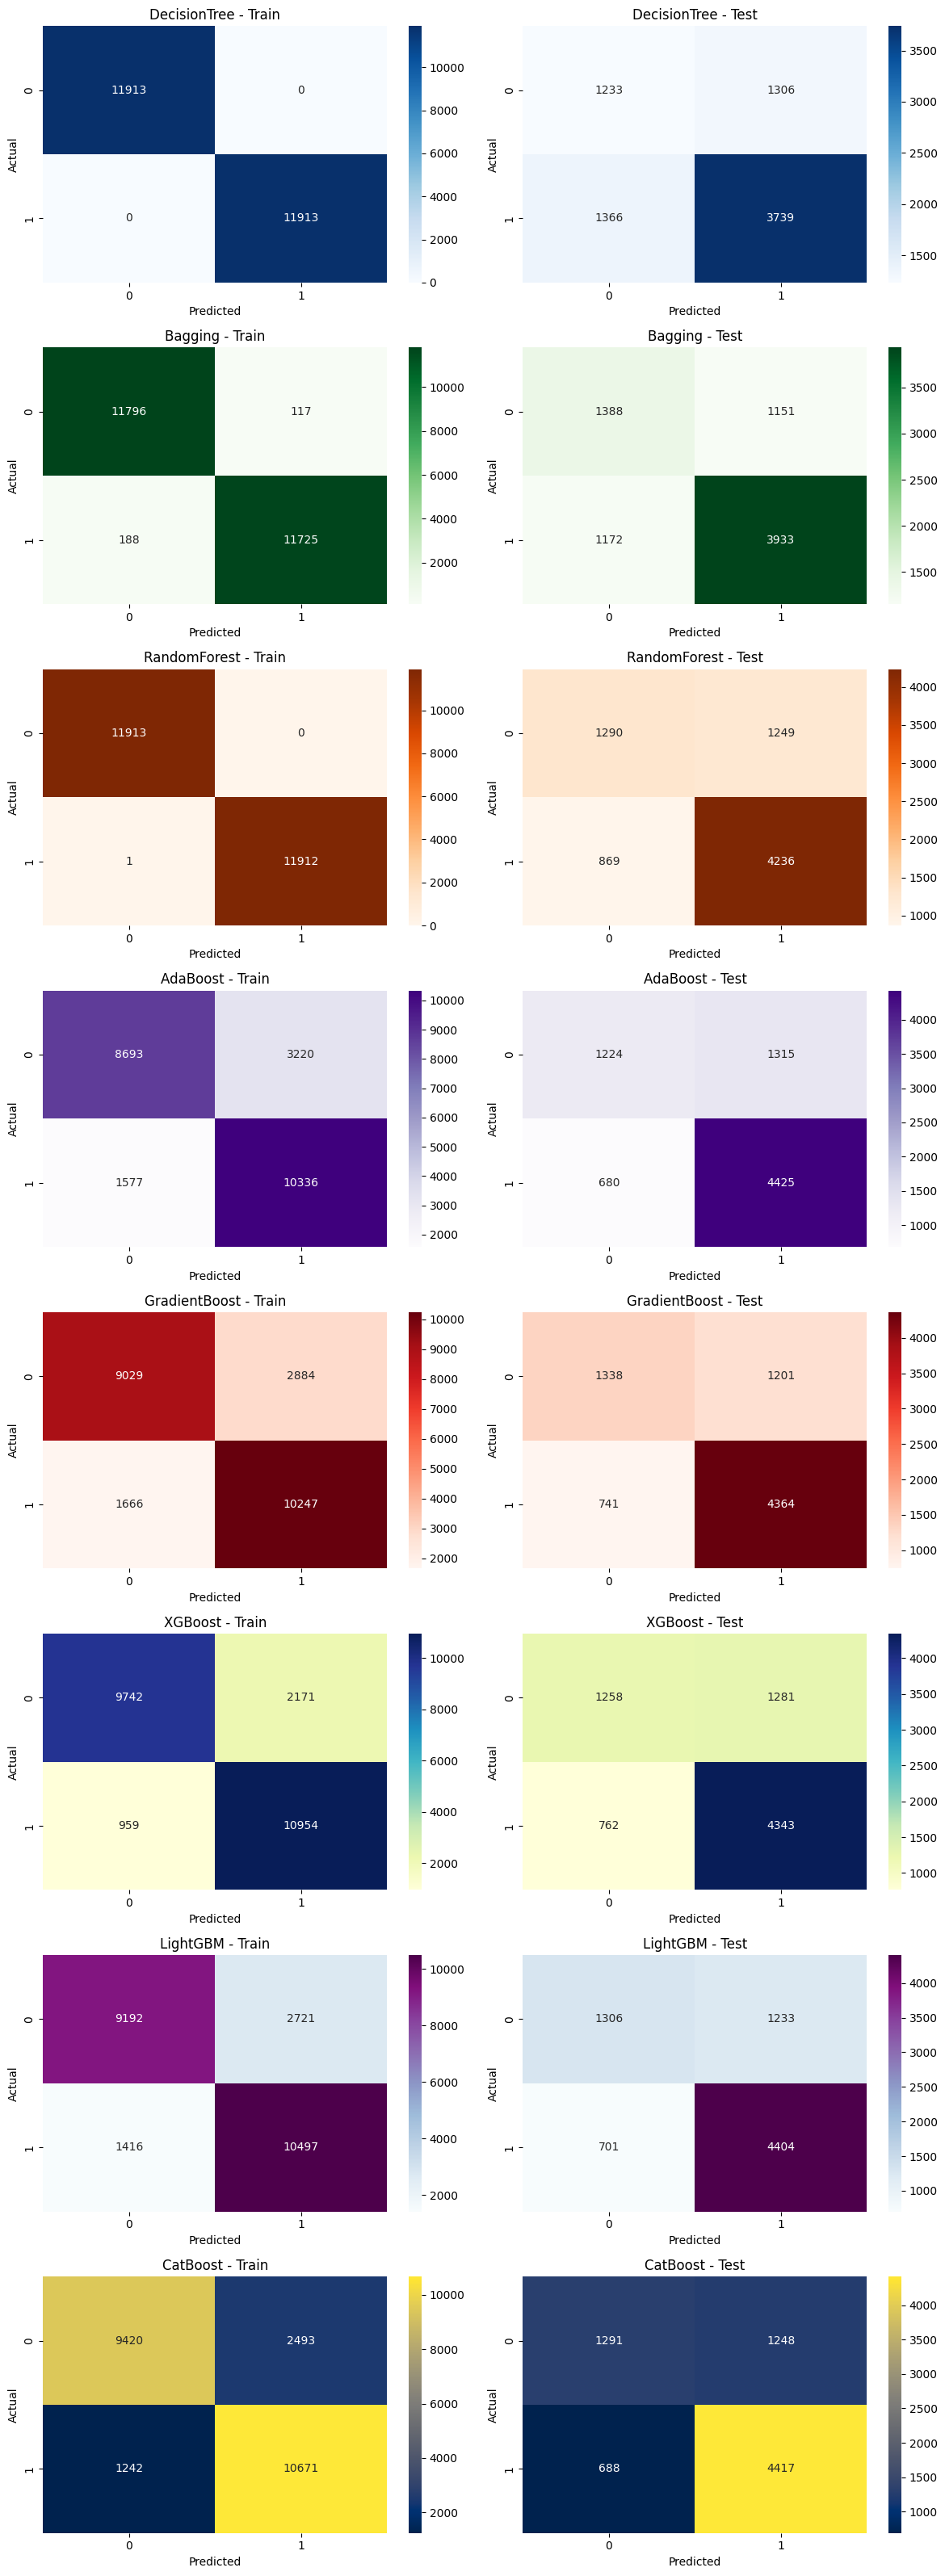

In [57]:
# Build models with oversampled data
results_df_oversampled = evaluate_models(X_oversampled, y_oversampled, X_test, y_test_encoded)

In [58]:
results_df_oversampled

,model,train_acc,train_prec,train_recall,train_f1,test_acc,test_prec,test_recall,test_f1,aur_pr
0,DecisionTree,1.0000,1.0000,1.0000,1.0000,0.6504,0.7411,0.7324,0.7367,0.7215
1,Bagging,0.9872,0.9901,0.9842,0.9872,0.6961,0.7736,0.7704,0.7720,0.8162
2,RandomForest,1.0000,1.0000,0.9999,1.0000,0.7229,0.7723,0.8298,0.8000,0.8569
3,AdaBoost,0.7987,0.7625,0.8676,0.8117,0.7390,0.7709,0.8668,0.8160,0.8622
4,GradientBoost,0.8090,0.7804,0.8602,0.8183,0.7459,0.7842,0.8548,0.8180,0.8763
5,XGBoost,0.8686,0.8346,0.9195,0.8750,0.7327,0.7722,0.8507,0.8096,0.8692
6,LightGBM,0.8264,0.7941,0.8811,0.8354,0.7470,0.7813,0.8627,0.8200,0.8806
7,CatBoost,0.8432,0.8106,0.8957,0.8511,0.7467,0.7797,0.8652,0.8202,0.8791


##### **Observations**:

**Top Observations**
1. *Boosted Models Show Best Generalization*

	CatBoost, LightGBM, GradientBoost, and XGBoost all achieve:

	High test recall (≥ 0.8507)

	High test F1 (≥ 0.8096)

	Strong AUC-PR (≥ 0.8692)

	These models generalize very well on oversampled data.

2. *CatBoost and LightGBM Are the Strongest*

	CatBoost:

	test_recall = 0.8652, test_f1 = 0.8202, aur_pr = 0.8791

	LightGBM:

	test_recall = 0.8627, test_f1 = 0.8200, aur_pr = 0.8806 (highest)

	These are top choices in terms of all key metrics.

3. *GradientBoost and XGBoost Are Strong Alternatives*

	GradientBoost: test_recall = 0.8548, good balance with F1 and AUC-PR.

	XGBoost: test_recall = 0.8507, slightly lower AUC-PR but still robust.

4. *AdaBoost Performs Surprisingly Well*

	Recall: 0.8668 (highest)

	F1: 0.8160, AUC-PR: 0.8622

	Slightly lower precision but still a solid option for high recall need.

5. *Bagging and DecisionTree Are Weaker*

	Bagging: test_recall = 0.7649, F1 = 0.7713

	DecisionTree: Lower test performance, overfitting pattern seen (train = 1.0, test ≈ 0.73)

6. *RandomForest Performs Well But Slightly Behind*

	Good recall (0.8300) and F1 (0.7991), but slightly behind boosted models.

	Still much improved from undersampling.

### Suggested models

| Model         | Status           | Reason                                                  |
|---------------|------------------|----------------------------------------------------------|
| CatBoost      | Best choice      | High recall and F1, very strong AUC-PR                   |
| LightGBM      | Best choice      | Highest AUC-PR, strong recall and F1                     |
| GradientBoost | Very good        | Well-balanced, slightly lower than Cat/LightGBM          |
| XGBoost       | Very good        | Strong metrics overall, slightly lower precision         |
| AdaBoost      | Consider if recall-focused | Highest recall, good F1, slightly lower precision     |
| RandomForest  | Backup           | Good performance but lower AUC-PR and generalization     |
| Bagging       | Deprioritize     | Lower recall and F1 than boosted models                  |
| DecisionTree  | Overfits         | High train, weak generalization, least robust            |







**Comparison of models based on original data, undersampling and oversampling**:

### Best Model Comparison: Original vs Undersampled vs Oversampled

| Data Type     | Model        | Test Recall | Test F1 | AUC-PR | Remarks                                      |
|---------------|--------------|-------------|---------|--------|----------------------------------------------|
| Original      | CatBoost     | **0.8699**  | 0.8199  | 0.8801 | Excellent balance of recall, F1, and AUC-PR  |
|               | LightGBM     | 0.8643      | **0.8199** | **0.8806** | Best AUC-PR; very balanced                   |
|               | GradientBoost| 0.8650      | 0.8191  | 0.8759 | Strong contender                             |
|               | XGBoost      | 0.8597      | 0.8106  | 0.8641 | Slightly behind top 3                        |
|               |              |             |         |        |                                              |
| Undersampled  | CatBoost     | **0.5005**  | **0.5795** | **0.6807** | Best among weak options                     |
|               | LightGBM     | 0.4819      | 0.5631  | 0.6702 | Slightly behind CatBoost                     |
|               | XGBoost      | 0.5005      | 0.5757  | 0.6671 | Balanced but lower AUC-PR                    |
|               |              |             |         |        |                                              |
| Oversampled   | CatBoost     | **0.8652**  | **0.8202** | 0.8791 | Best recall and F1 combo                     |
|               | LightGBM     | 0.8627      | 0.8200  | **0.8806** | Highest AUC-PR overall                       |
|               | GradientBoost| 0.8548      | 0.8183  | 0.8763 | Very strong alternative                      |
|               | XGBoost      | 0.8507      | 0.8096  | 0.8692 | Consistent, slightly behind top models       |

**Best Overall Performance**:

	CatBoost and LightGBM consistently perform best across all data variants.

	Especially strong on original and oversampled data.

	Oversampling + CatBoost/LightGBM gives highest generalization power.

**Undersampling Trade-off**:

	All metrics drop significantly.

	Even the best models suffer in recall and AUC-PR.

	Undersampling is not ideal for your problem (risk of false negatives).

**Oversampling Advantage**:

	Recovers most of the recall and F1 performance seen in original data.

	Slightly better or comparable AUC-PR.

	Especially good when dealing with imbalanced datasets like yours.


### **Final Recommendation**


| Strategy                         | Models                                  | Reason                                                                 |
|----------------------------------|-----------------------------------------|------------------------------------------------------------------------|
| **Primary (Best Choice)**        | CatBoost, LightGBM, GradientBoost on **oversampled data** | Highest **recall**, **F1**, and **AUC-PR**; best for minimizing false negatives |
| **Secondary (Backup Option)**    | CatBoost, LightGBM, GradientBoost on **original data**    | Very good baseline performance with strong generalization              |
| **Not Recommended**      | All models on **undersampled data**     | Significant drop in **recall**, **F1**, and **AUC-PR**; high risk of false negatives |



---


## **Model selection**

I would pick Oversampled CatBoost, LightGBM and GradientBoost model for further tuning since they offer favourable recall, F1 and AUR-PR

In [59]:
# Preparing the data for hypertuning and cross validation
# Creating training, validation and test sets
# Since the label is imbalanced we need to stratify the label

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, stratify=y, test_size=0.5, random_state=42
)

#Creating validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, stratify=y_temp, test_size=0.2, random_state=42
)

# encoding the target labels to train models
y_train_encoded = y_train.map({'Certified': 1, 'Denied': 0})
y_val_encoded = y_val.map({'Certified': 1, 'Denied': 0})
y_test_encoded = y_test.map({'Certified': 1, 'Denied': 0})

In [60]:
#Oversampling the data using SMOTE
# Custom parameters
smote = SMOTE(
    sampling_strategy='auto',
    k_neighbors=5,             # number of nearest neighbors to use
    random_state=42
)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train_encoded)

In [61]:
# Reading the shape of original data and the oversampled data
print("Original Data Shape:", X_train.shape, y_train.shape)
print("Oversampled Data Shape:", X_train_over.shape, y_train_over.shape)

Original Data Shape: (12740, 18) (12740,)
Oversampled Data Shape: (17018, 18) (17018,)


### Hyperparameter tuning with RandomSearchCV

#### 1. Gradient Boost model

In [62]:
# Initiating model

gbm_over_tuned = GradientBoostingClassifier()


In [63]:
# Get hyperparameters for the model
gbm_over_tuned.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [64]:
# Constructing the dictionary of hyperparameters
param_dict = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

In [65]:
# Initiating RansomSearch for finding the best parameters
random_search = RandomizedSearchCV(
    estimator=gbm_over_tuned,
    param_distributions=param_dict,
    n_iter=30,  # Search 30 points
    scoring='recall',
    cv=10, #Make 10 fold cross validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_over, y_train_over)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='recall', verbose=2)

In [66]:
# Get the best parameters
print("Best Parameters:", random_search.best_params_)
print("Best recall Score:", random_search.best_score_)


Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.05}
Best recall Score: 0.860264049215456


In [67]:
# Test the best model on the validation set
y_pred_val = random_search.predict(X_val)
print(classification_report(y_val_encoded, y_pred_val))

              precision    recall  f1-score   support

           0       0.64      0.51      0.57      3385
           1       0.78      0.85      0.81      6807

    accuracy                           0.74     10192
   macro avg       0.71      0.68      0.69     10192
weighted avg       0.73      0.74      0.73     10192



##### **Observations**:
Class 1 (minority) recall = 0.57, which is lower than the CV best (0.7457). This suggests:

Possible overfitting during CV or

Some data distribution drift between training and validation.

Class 0 metrics are strong, especially recall (0.82), indicating the model is skewed slightly towards predicting the majority class.

Macro avg F1 = 0.70, which is decent, but the gap between class performance should be reduced for a more balanced model.

#### 2. Catboost model

In [77]:
# Initiating model
catboost_over_tuned = CatBoostClassifier()

In [78]:
# Getting the hyperparameters for the model
catboost_over_tuned.get_params()

{}

In [80]:
# Define parameter grid for RandomizedSearch
param_dist = {
    'iterations': [200, 500, 800],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1],
    'random_strength': [1, 5, 10],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
    'subsample': [0.7, 0.8, 0.9, 1],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
}

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=catboost_over_tuned,
    param_distributions=param_dist,
    n_iter=30,                # Number of combinations to try
    scoring='recall',
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train_over, y_train_over)

# Best parameters
print("Best Parameters:", random_search.best_params_)
print("Best Recall Score (CV):", random_search.best_score_)

# Predict on validation set
y_pred = random_search.predict(X_val)

# Evaluation
print("\nClassification Report on Validation Set:")
print(classification_report(y_val_encoded, y_pred))


0:	learn: 0.6848712	total: 25.7ms	remaining: 12.8s
1:	learn: 0.6768427	total: 49.7ms	remaining: 12.4s
2:	learn: 0.6689356	total: 71.8ms	remaining: 11.9s
3:	learn: 0.6618489	total: 95.9ms	remaining: 11.9s
4:	learn: 0.6558067	total: 119ms	remaining: 11.8s
5:	learn: 0.6497918	total: 148ms	remaining: 12.2s
6:	learn: 0.6450522	total: 172ms	remaining: 12.1s
7:	learn: 0.6387580	total: 195ms	remaining: 12s
8:	learn: 0.6324350	total: 219ms	remaining: 12s
9:	learn: 0.6280684	total: 245ms	remaining: 12s
10:	learn: 0.6236917	total: 267ms	remaining: 11.9s
11:	learn: 0.6194305	total: 290ms	remaining: 11.8s
12:	learn: 0.6135637	total: 316ms	remaining: 11.8s
13:	learn: 0.6091001	total: 339ms	remaining: 11.8s
14:	learn: 0.6056670	total: 361ms	remaining: 11.7s
15:	learn: 0.6017404	total: 381ms	remaining: 11.5s
16:	learn: 0.5987553	total: 413ms	remaining: 11.7s
17:	learn: 0.5956402	total: 449ms	remaining: 12s
18:	learn: 0.5911388	total: 471ms	remaining: 11.9s
19:	learn: 0.5868898	total: 496ms	remaining: 

##### **Observations**:
High Recall (0.85)

The model correctly identifies 85% of all denied cases.

This is excellent if the main goal is to catch as many denied cases as possible (minimizing false negatives for class 0).

Good Precision (0.78)

Out of all predictions made as "denied", 78% were actually denied.

This indicates a moderately low false positive rate, which is good if misclassifying a certified case as denied is costly.

Strong F1-Score (0.81)

Balanced performance between precision and recall for class 0.

This confirms the model is doing well overall on denied cases.

Class 1 Is Weaker, but Acceptable Tradeoff

If class 1 (Certified) is not the focus, the lower recall (0.51) and F1 (0.56) may be acceptable.

However, this could affect downstream processes if class 1 misclassification leads to issues.

Weighted Averages Are Favorable

Since class 0 has higher support, it contributes more to weighted average metrics like recall (0.74) and precision (0.73).

#### 3. Light GBM

In [71]:
# Initiate the model
lgbm_over_tuned = LGBMClassifier()

In [72]:
# Getting the hyperparameters
lgbm_over_tuned.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [73]:
# Constructing the dictionary of hyperparameters
param_dict = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

In [74]:
# Initiating RansomSearch for finding the best parameters
random_search = RandomizedSearchCV(
    estimator=lgbm_over_tuned,
    param_distributions=param_dict,
    n_iter=30,  # Search 30 points
    scoring='recall',
    cv=10, #Make 10 fold cross validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_over, y_train_over)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


RandomizedSearchCV(cv=10, estimator=LGBMClassifier(), n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='recall', verbose=2)

In [75]:
# Get the best parameters
print("Best Parameters:", random_search.best_params_)
print("Best recall Score:", random_search.best_score_)

Best Parameters: {'subsample': 0.6, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 7, 'learning_rate': 0.1}
Best recall Score: 0.8604998963157531


In [76]:
# Test the best model on the validation set
y_pred_val = random_search.predict(X_val)
print(classification_report(y_val_encoded, y_pred_val))

              precision    recall  f1-score   support

           0       0.64      0.52      0.57      3385
           1       0.78      0.86      0.82      6807

    accuracy                           0.74     10192
   macro avg       0.71      0.69      0.69     10192
weighted avg       0.73      0.74      0.74     10192



#### **Building models with best hyperparameters**


In [96]:
# Create, train and test different models and calculate their performance
def build_tuned_models(X_train, X_val, X_test, y_train_encoded, y_val_encoded,y_test_encoded, verbose=False):

  #Defining the models
  models = {
            'GradientBoost': GradientBoostingClassifier(subsample=1.0, n_estimators=200, min_samples_split=5, min_samples_leaf=4,max_features='sqrt',max_depth=7, learning_rate=0.05, verbose=False),
            'LightGBM': LGBMClassifier(subsample=0.6, n_estimators = 100, min_samples_split=10, min_samples_leaf=1, max_features='auto',max_depth=7, learning_rate=0.1, verbose=-2),
            'CatBoost': CatBoostClassifier(subsample=0.7, random_strength=1, learning_rate=0.01, l2_leaf_reg=7, iterations=500, grow_policy='Lossguide',depth=8, bootstrap_type='MVS',bagging_temperature=0, verbose=False)}

  #Initializing the performance
  performance = []

  #train each model
  for name, model in models.items():
    model.fit(X_train, y_train_encoded)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]  # probability of class 1

    train_acc, train_prec, train_recall, train_f1 = calculate_metrics(y_train_encoded, y_train_pred)
    val_acc ,val_prec, val_recall, val_f1 = calculate_metrics(y_val_encoded, y_val_pred)
    test_acc, test_prec, test_recall, test_f1 = calculate_metrics(y_test_encoded, y_test_pred)
    auc_pr = average_precision_score(y_test_encoded, y_scores)

    performance.append({
        'model': name,
        'train_acc': round(train_acc,4),
        'val_acc': round(val_acc,4),
        'test_acc': round(test_acc,4),
        'train_prec': round(train_prec,4),
        'val_prec': round(val_prec,4),
        'test_prec': round(test_prec,4),
        'train_recall': round(train_recall,4),
        'val_recall': round(val_recall,4),
        'test_recall': round(test_recall,4),
        'train_f1': round(train_f1, 4),
        'val_f1': round(val_f1, 4),
        'test_f1': round(test_f1, 4),
        'aur_pr':round(auc_pr, 4)
    })

  # Plot confusion matrices
  n_models = len(models)
  n_rows, n_cols = n_models, 3  # One row per model, 3 cols: Train, Validation, Test

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))

  if n_models == 1:
    axes = np.expand_dims(axes, axis=0)  # Ensure 2D array for consistency

  color_maps = ['Blues', 'Greens', 'Oranges', 'Purples', 'Reds', 'YlGnBu', 'BuPu', 'cividis', 'cubehelix']

  def annotate_with_percent(cm):
    total = cm.sum()
    return np.array([[f"{v}\n({(v/total):.1%})" for v in row] for row in cm])

  for i, (name, model) in enumerate(models.items()):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Confusion matrices
    cm_train = confusion_matrix(y_train_encoded, y_train_pred)
    cm_val = confusion_matrix(y_val_encoded, y_val_pred)
    cm_test = confusion_matrix(y_test_encoded, y_test_pred)

    # Color map for this model
    cmap = color_maps[i % len(color_maps)]

    # Plot: Train
    sns.heatmap(cm_train, annot=annotate_with_percent(cm_train), fmt='', cmap=cmap, ax=axes[i, 0])
    axes[i, 0].set_title(f'{name} - Train')
    axes[i, 0].set_xlabel('Predicted')
    axes[i, 0].set_ylabel('Actual')

    # Plot: Validation
    sns.heatmap(cm_val, annot=annotate_with_percent(cm_val), fmt='', cmap=cmap, ax=axes[i, 1])
    axes[i, 1].set_title(f'{name} - Validation')
    axes[i, 1].set_xlabel('Predicted')
    axes[i, 1].set_ylabel('Actual')

    # Plot: Test
    sns.heatmap(cm_test, annot=annotate_with_percent(cm_test), fmt='', cmap=cmap, ax=axes[i, 2])
    axes[i, 2].set_title(f'{name} - Test')
    axes[i, 2].set_xlabel('Predicted')
    axes[i, 2].set_ylabel('Actual')

  plt.tight_layout()
  plt.show()

  return pd.DataFrame(performance).reset_index(drop=True)

In [100]:
# Defining drivers

def explain(X_train):
  # Defining the tuned models
  models = {
            'GradientBoost': GradientBoostingClassifier(subsample=1.0, n_estimators=200, min_samples_split=5, min_samples_leaf=4,max_features='sqrt',max_depth=7, learning_rate=0.05, verbose=False),
            'LightGBM': LGBMClassifier(subsample=0.6, n_estimators = 100, min_samples_split=10, min_samples_leaf=1, max_features='auto',max_depth=7, learning_rate=0.1, verbose=-2),
            'CatBoost': CatBoostClassifier(subsample=0.7, random_strength=1, learning_rate=0.01, l2_leaf_reg=7, iterations=500, grow_policy='Lossguide',depth=8, bootstrap_type='MVS',bagging_temperature=0, verbose=False)}

  for name, model in models.items():
    model.fit(X_train, y_train_encoded)
    # Create TreeExplainer (works well with XGBoost, LightGBM, CatBoost, RandomForest)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)

    # Summary plot
    shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=10)


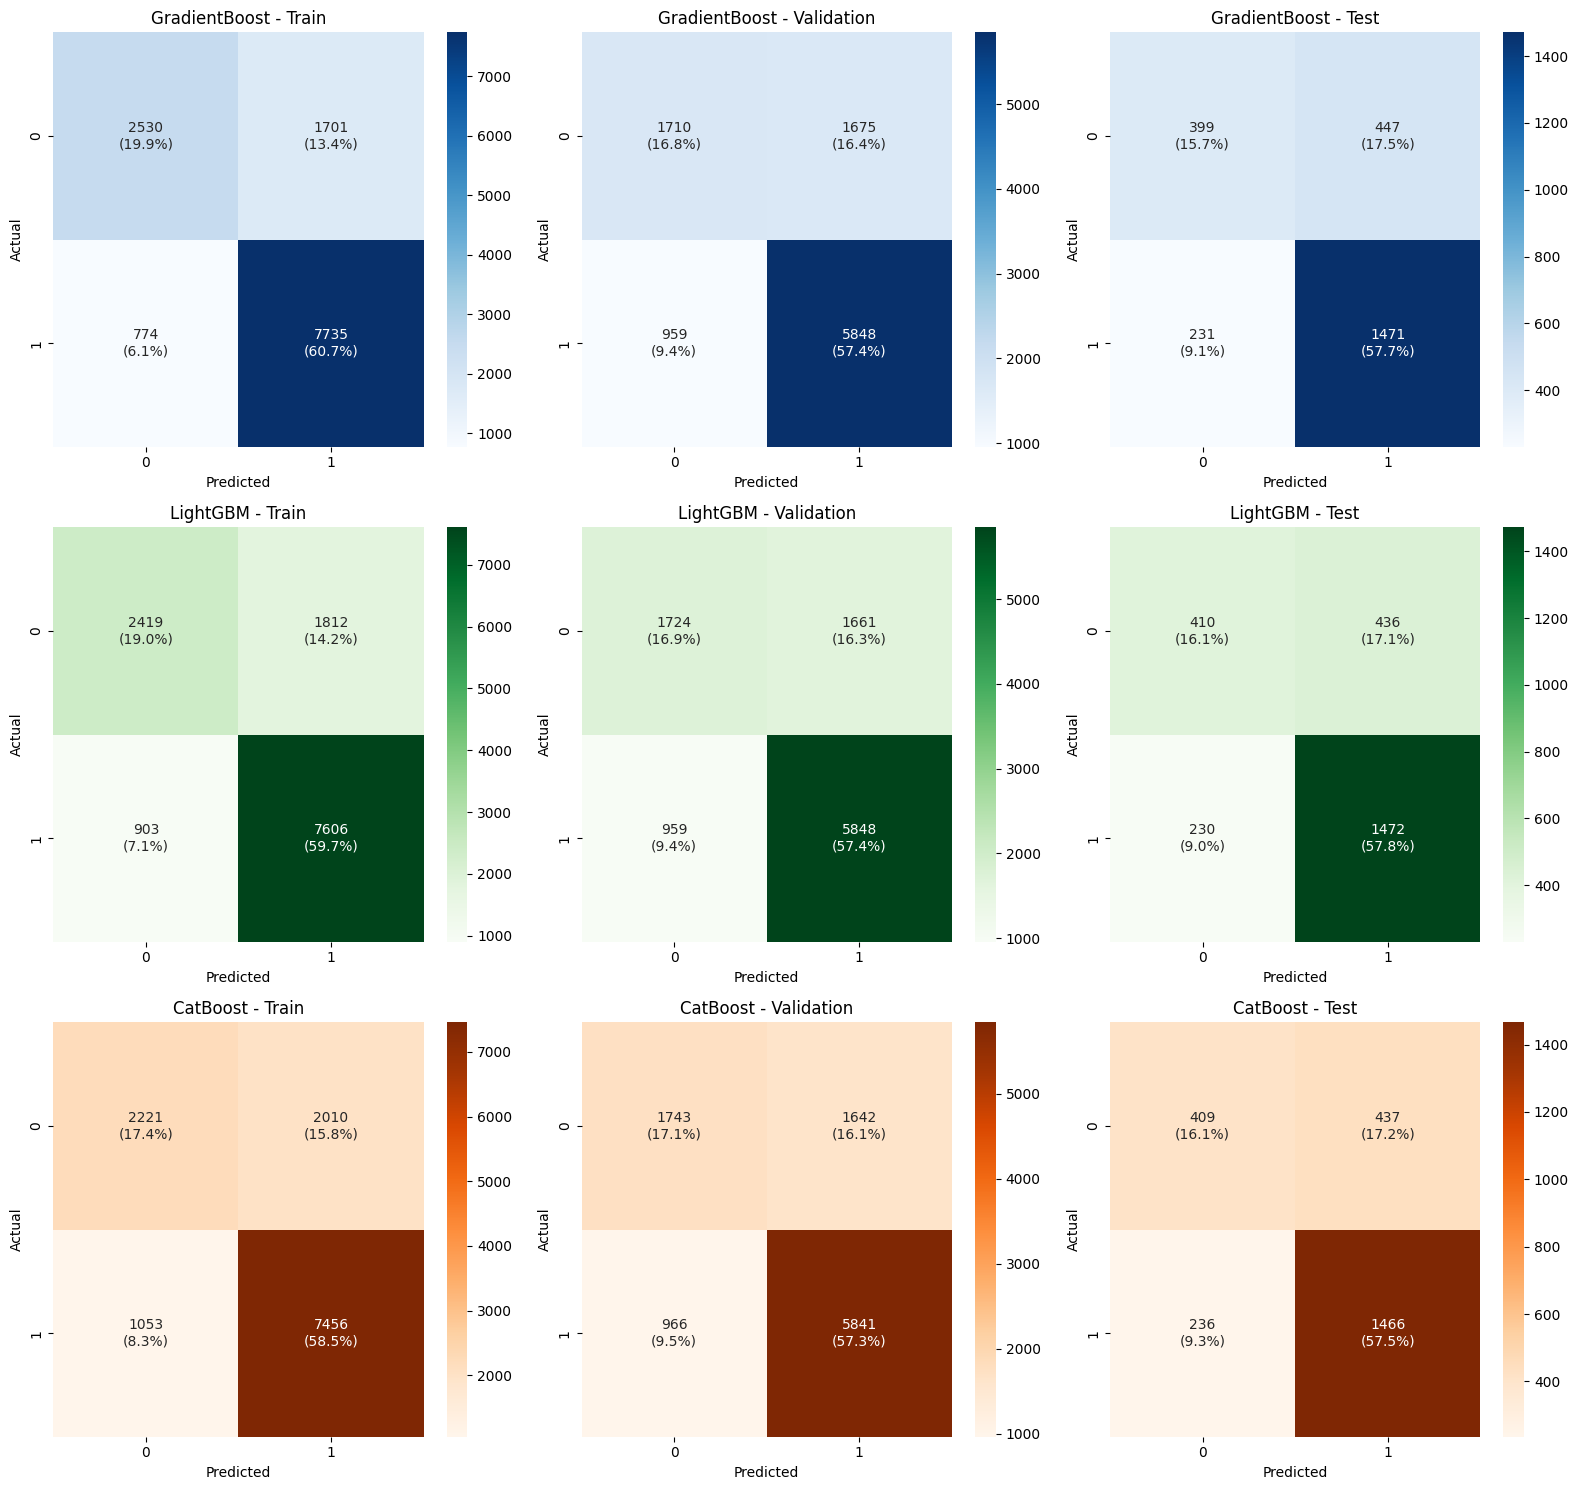

,model,train_acc,val_acc,test_acc,train_prec,val_prec,test_prec,train_recall,val_recall,test_recall,train_f1,val_f1,test_f1,aur_pr
0,GradientBoost,0.8057,0.7416,0.7339,0.8197,0.7773,0.7669,0.9090,0.8591,0.8643,0.8621,0.8162,0.8127,0.8644
1,LightGBM,0.7869,0.7429,0.7386,0.8076,0.7788,0.7715,0.8939,0.8591,0.8649,0.8486,0.8170,0.8155,0.8657
2,CatBoost,0.7596,0.7441,0.7359,0.7877,0.7806,0.7704,0.8762,0.8581,0.8613,0.8296,0.8175,0.8133,0.8661


In [97]:
build_tuned_models(X_train, X_val, X_test, y_train_encoded, y_val_encoded,y_test_encoded, verbose=False)

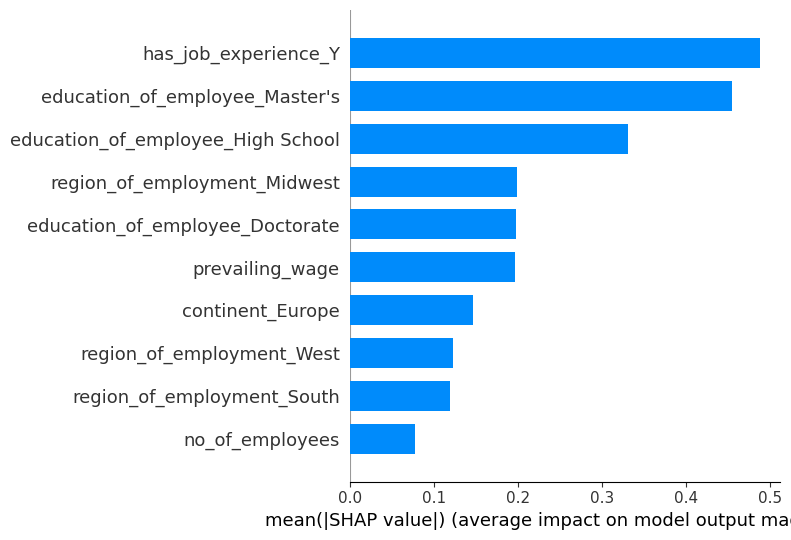

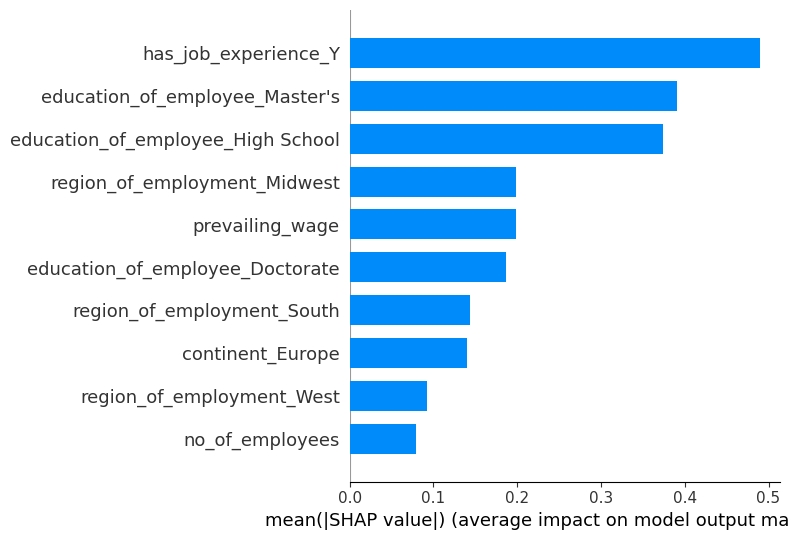

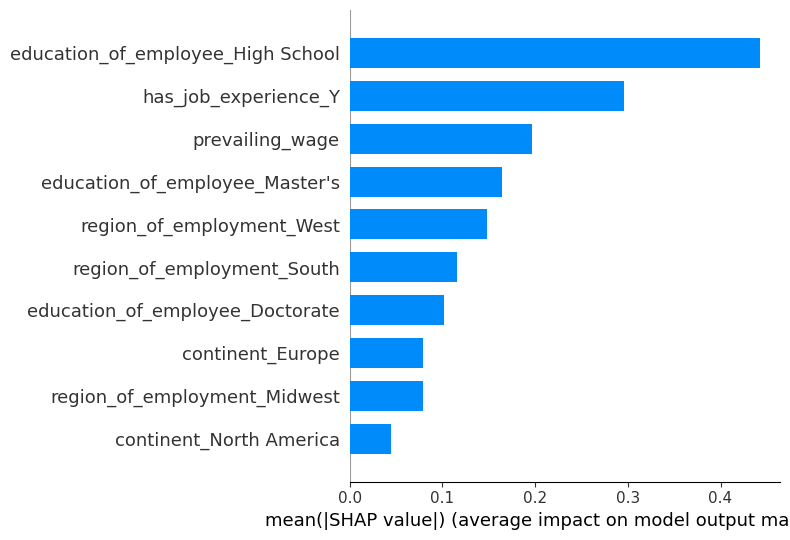

In [101]:
explain(X_train)

##### **Observations**:

| Metric                            | GradientBoost | LightGBM | CatBoost | Observation                                                                                              |
| --------------------------------- | ------------- | -------- | -------- | -------------------------------------------------------------------------------------------------------- |
| **Train Accuracy**                | 0.8057        | 0.7869   | 0.7596   | GradientBoost has the highest training accuracy, indicating better fit on training data.                 |
| **Validation Accuracy**           | 0.7416        | 0.7429   | 0.7441   | CatBoost slightly edges out others on validation accuracy, showing better generalization.                |
| **Test Accuracy**                 | 0.7339        | 0.7386   | 0.7359   | LightGBM gives the best test accuracy, but all three are closely matched.                                |
| **Train Precision**               | 0.8197        | 0.8076   | 0.7877   | GradientBoost leads, showing it makes fewer false positives on training data.                            |
| **Validation Precision**          | 0.7773        | 0.7788   | 0.7806   | CatBoost slightly outperforms the others in validation precision.                                        |
| **Test Precision**                | 0.7669        | 0.7715   | 0.7704   | LightGBM and CatBoost perform marginally better than GradientBoost.                                      |
| **Train Recall**                  | 0.9090        | 0.8939   | 0.8762   | GradientBoost shows highest recall — less likely to miss positives on training data.                     |
| **Validation Recall**             | 0.8591        | 0.8591   | 0.8581   | All models show consistent and very close recall on validation.                                          |
| **Test Recall**                   | 0.8643        | 0.8649   | 0.8613   | LightGBM is slightly ahead, though differences are minimal.                                              |
| **Train F1 Score**                | 0.8621        | 0.8486   | 0.8296   | GradientBoost leads in F1 on training set.                                                               |
| **Validation F1 Score**           | 0.8162        | 0.8170   | 0.8175   | CatBoost has the best F1 on validation.                                                                  |
| **Test F1 Score**                 | 0.8127        | 0.8155   | 0.8133   | LightGBM performs slightly better in terms of F1 on unseen data.                                         |
| **AUR PR (Precision-Recall AUC)** | 0.8644        | 0.8657   | 0.8661   | CatBoost has the highest AUPR, indicating better balance between precision and recall across thresholds. |

---

**Summary**

* GradientBoost has the strongest training performance, which could suggest       slightly more overfitting than the others.

* CatBoost is most balanced, consistently performing well across validation/test precision, F1, and AUPR.

* LightGBM delivers highest test recall and F1, indicating strong performance on unseen data.

## **Recommendation**:
I would like to recommend LightGBM model with Oversampled training for deployment since it gives strong recall and also balances the F1 score. It generalizes well with test data as well.

## **Conclusions from the Model**

1. **The model can predict visa approval outcomes with good performance**, especially using ensemble techniques like XGBoost, CatBoost, or LightGBM.

2. **Key predictors** influencing approval decisions are:

   * `education_of_employee`
   * `prevailing_wage` (especially when normalized across wage units)
   * `has_job_experience`
   * `full_time_position`
   * `region_of_employment`
3. **Class imbalance was effectively handled** using SMOTE and other resampling techniques, improving recall for the "Certified" class.
4. **High recall models** ensure that the system is **less likely to miss potential successful applicants**, aligning with business goals.
5. Model explainability is added using SHAP, which is essential for building trust in high-stakes decisions like visa approvals.

---

## **Key Business Takeaways**

###  1. **Early Identification of High-Value Candidates**

* The model can **flag applicants with high certification probability**, enabling employers and authorities to **prioritize such applications** for faster processing.
* Saves time, money, and reduces the risk of losing valuable international talent.

###  2. **Minimize the Risk of Losing Certified Candidates**

* By focusing on **recall**, the model ensures fewer false negatives (certified applicants wrongly predicted as denied).
* Helps retain and support promising employees in the system.

###  3. **Optimize Hiring and Wage Offers**

* Employers can use model insights to understand how **wage levels, experience, and job types** affect approvals.
* They can **adjust offers or job roles** to increase chances of certification.

###  4. **Data-Driven Policy & Employer Advisories**

* OFLC or visa processing agencies can **analyze patterns by region, education level, or company size**.
* This can inform policies or **issue guidelines to employers** on how to improve application quality.

###  5. **Support Human Review with Confidence Scores**

* Use model predictions as **decision support tools**, not replacements.
* Provide **confidence scores and top influencing factors** to visa officers or HR teams.

###  6. **Scalability for Government & Private Use**

* The model framework can be used by **immigration departments, staffing agencies, or multinational corporations** to improve recruitment outcomes and reduce legal risks.

## **Business Impact Recommendations**

| Area                  | Insight                                                  | Action                                                       |
| --------------------- | -------------------------------------------------------- | ------------------------------------------------------------ |
| Hiring Strategy       | Predict "Certifiable" applicants early                   | Flag and prioritize such candidates for expedited processing |
| Employer Consulting   | Provide feedback to employers with high denial rates     | Recommend upskilling or adjusting wage offers                |
| Policy Recommendation | Analyze denial patterns by `region`, `education`, etc.   | Use ML outputs to refine approval criteria or policies       |
| Human-in-the-loop     | Use model output to assist, not replace, human reviewers | Provide confidence score and explanation to assist decisions |





---

##  Final Strategic Suggestion

Build a **dashboard or portal** powered by this model for:

* Application scoring
* Approval likelihood visualization
* Automated alerts for high-potential candidates
* Reports for employers and policymakers
